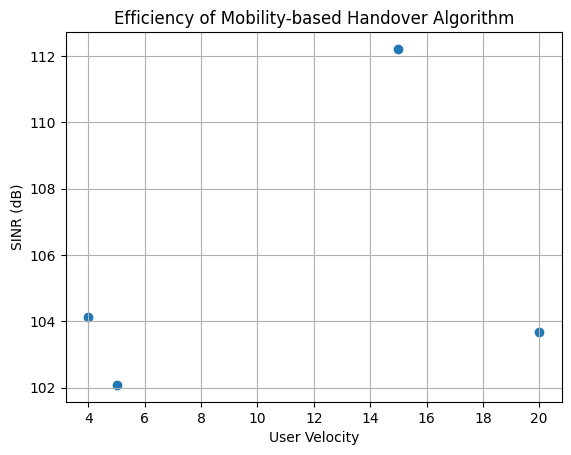

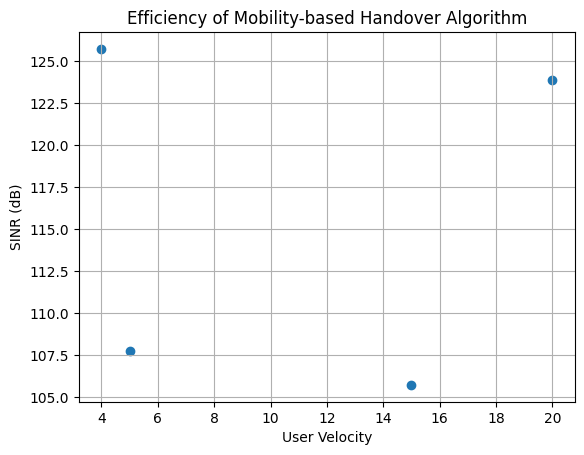

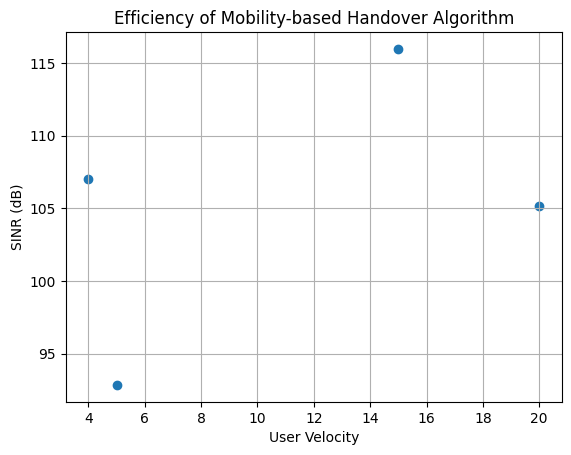

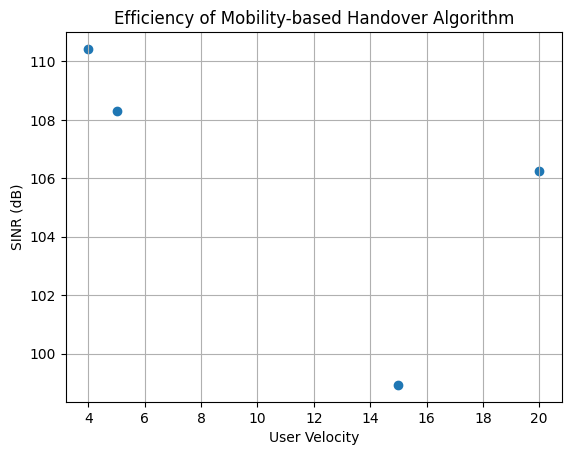

User 1 should handover to base station BS2
User 2 should handover to base station BS1
User 3 should handover to base station BS1
User 4 should handover to base station BS1
User 5 should handover to base station BS1
Signal Strength-based Handover:
  Average SINR: 105.53 dB
  Handover Rate: 60.00%
  Average Throughput: 404047833.07 bps
Average Latency: 0.00 ms
Average Packet Loss: 0.00%
Average Energy Consumption: 0.00 units
Average Jitter: 6.25 ms
User Mobility-based Handover:
  Average SINR: 115.78 dB
  Handover Rate: 60.00%
  Average Throughput: 411796549.75 bps
Average Latency: 0.00 ms
Average Packet Loss: 0.00%
Average Energy Consumption: 0.00 units
Average Jitter: 6.82 ms
Hybrid Handover:
  Average SINR: 105.26 dB
  Handover Rate: 60.00%
  Average Throughput: 403621193.57 bps
Average Packet Loss: 0.00%
Average Energy Consumption: 0.00 units
Average Jitter: 3.84 ms
Enhanced Hybrid Handover:
  Average SINR: 105.98 dB
  Handover Rate: 60.00%
  Average Throughput: 404395971.07 bps
Aver

In [ ]:
import math
import numpy as np
import matplotlib.pyplot as plt
import random

lte_params = {
    'frequency': 1800,  # in MHz
    'bs_tx_power': 46,  # in dBm
    'noise_figure': 9,  # in dB
    'bandwidth': 10e6,  # in Hz
    'coding_rate': 0.75,  # Coding rate
    'mimo_config': (2, 2),  # MIMO configuration as (number of transmit antennas, number of receive antennas)
    'carrier_aggregation': 2,  # Number of aggregated carriers{'primary_band': 1800, 'secondary_band': 2100} Carrier Aggregation configuration
}
# Sample data for signal strengths, velocities, user locations, candidate base stations, network loads, and LTE parameters
signal_strengths = [-75, -85, -90, -70, -82]
velocities = [5, 15, 20, 4, 12]
user_locations = [(0, 0, 1.5), (1, 1, 1.5), (2, 2, 1.5), (3, 3, 1.5), (6, 6, 30)]
candidate_base_stations = [
    {'id': 'BS1', 'location': (0, 0, 30)},
    {'id': 'BS2', 'location': (1, 1, 30)},
    {'id': 'BS3', 'location': (2, 2, 30)},
    {'id': 'BS4', 'location': (3, 3, 30)},
]

network_loads = [0.5, 0.3, 0.7, 0.4]  # Example network loads for each base station
modulation_schemes = {
    'QPSK': {'min_sinr': -6, 'max_sinr': 4, 'spectral_efficiency': 2},
    '16QAM': {'min_sinr': 4, 'max_sinr': 14, 'spectral_efficiency': 4},
    '64QAM': {'min_sinr': 14, 'max_sinr': 999, 'spectral_efficiency': 6}
}
def get_modulation_scheme(sinr):
    if sinr >= 20:
        return '64QAM'
    elif sinr >= 10:
        return '16QAM'
    elif sinr >= 0:
        return 'QPSK'
    else:
        return 'BPSK'
def determine_modulation_scheme(sinr, modulation_schemes):
    for modulation, params in modulation_schemes.items():
        if params['min_sinr'] <= sinr <= params['max_sinr']:
            return modulation
    return None

def calculate_throughput(sinr_values, bandwidth, modulation_schemes):
    throughputs = []
    for sinr in sinr_values:
        modulation_scheme = determine_modulation_scheme(sinr, modulation_schemes)
        spectral_efficiency = modulation_schemes[modulation_scheme]['spectral_efficiency']
        throughput = bandwidth * spectral_efficiency * math.log2(1 + sinr)
        throughputs.append(throughput)
    return throughputs

def calculate_average_sinr(sinr_values):
    valid_sinr_values = [sinr for sinr in sinr_values if sinr != -math.inf]
    return sum(valid_sinr_values) / len(valid_sinr_values)

def calculate_handover_rate(selected_base_stations, initial_base_stations):
    handover_count = sum(s1 != s2 for s1, s2 in zip(selected_base_stations, initial_base_stations))
    return handover_count / len(selected_base_stations)

def calculate_sinr_values(user_locations, selected_base_stations, network_loads, lte_params, previous_shadowing_values=None):
    sinr_values = []
    for i, (user_location, base_station, network_load) in enumerate(zip(user_locations, selected_base_stations, network_loads)):
        if base_station is not None:
            previous_shadowing = None if previous_shadowing_values is None else previous_shadowing_values[i]
            sinr = calculate_sinr(user_location, base_station, network_load, lte_params, previous_shadowing)
            sinr_values.append(sinr)
        else:
            sinr_values.append(-math.inf)
    return sinr_values
def plot_efficiency(sinr_values, velocities):
    valid_indices = [i for i, sinr in enumerate(sinr_values) if sinr != -math.inf]
    valid_sinr_values = [sinr_values[i] for i in valid_indices]
    valid_velocities = [velocities[i] for i in valid_indices]

    plt.scatter(valid_velocities, valid_sinr_values)
    plt.xlabel('User Velocity')
    plt.ylabel('SINR (dB)')
    plt.title('Efficiency of Mobility-based Handover Algorithm')
    plt.grid()
    plt.show()

def calculate_distance(user_location, base_station_location):
    dx = user_location[0] - base_station_location[0]
    dy = user_location[1] - base_station_location[1]
    dz = user_location[2] - base_station_location[2]
    distance = np.sqrt(dx**2 + dy**2 + dz**2)
    return distance

def calculate_sinr(user_location, base_station, network_load, lte_params, previous_shadowing=None):
    # Extract relevant LTE parameters
    frequency = lte_params['frequency']  # in MHz
    bs_tx_power = lte_params['bs_tx_power']  # in dBm
    coding_rate = lte_params['coding_rate']
    mimo_config = lte_params['mimo_config']
    carrier_aggregation = lte_params['carrier_aggregation']

    # Calculate path loss, shadowing, and fast fading effects
    path_loss = calculate_path_loss(user_location, base_station['location'], frequency)
    shadowing = calculate_correlated_shadowing(user_location, base_station['location'], previous_shadowing)
    fast_fading = calculate_fast_fading(user_location, base_station['location'])

    # Calculate received signal power at the user's location
    received_signal_power = bs_tx_power - path_loss + shadowing + fast_fading

    # Calculate the interference plus noise power
    interference_plus_noise = calculate_interference_plus_noise(user_location, network_load, lte_params)

    # Calculate SINR
    sinr = received_signal_power - interference_plus_noise

    # Get the modulation scheme based on SINR value
    modulation_scheme = get_modulation_scheme(sinr)

    # Calculate spectral efficiency
    #spectral_efficiency = calculate_spectral_efficiency(sinr, modulation_scheme, coding_rate, mimo_config, carrier_aggregation)

    return sinr#, spectral_efficiency

def calculate_3gpp_path_loss(user_location, base_station_location, frequency, environment, h_ue, h_bs):
    # Implement the 3GPP 36.931 path loss model for different environments
    distance = calculate_distance(user_location, base_station_location)
    if environment == "urban":
        path_loss = 161.04 - 7.1 * np.log10(h_bs) + 7.5 * np.log10(h_ue) - (44.49 - 6.55 * np.log10(h_bs)) * np.log10(distance) - 20 * np.log10(frequency)
    elif environment == "suburban":
        path_loss = 161.04 - 7.1 * np.log10(h_bs) + 7.5 * np.log10(h_ue) - (44.49 - 6.55 * np.log10(h_bs)) * np.log10(distance) - 20 * np.log10(frequency) + 5
    elif environment == "rural":
        path_loss = 161.04 - 7.1 * np.log10(h_bs) + 7.5 * np.log10(h_ue) - (44.49 - 6.55 * np.log10(h_bs)) * np.log10(distance) - 20 * np.log10(frequency) + 20
    else:
        raise ValueError("Invalid environment specified")
    return path_loss

def calculate_path_loss(user_location, base_station_location, frequency):
    environment = "urban"  # Choose the environment: "urban", "suburban", or "rural"
    h_ue = user_location[2]  # User antenna height in meters
    h_bs = base_station_location[2]  # Base station antenna height in meters
    path_loss = calculate_3gpp_path_loss(user_location, base_station_location, frequency, environment, h_ue, h_bs)
    return path_loss


def calculate_correlated_shadowing(user_location, base_station_location, previous_shadowing_value=None):
    shadowing_std_dev = 8  # Example standard deviation for shadowing in dB
    correlation_distance = 50  # Correlation distance in meters
    distance = calculate_distance(user_location, base_station_location)

    if previous_shadowing_value is not None:
        # Calculate the correlation coefficient based on the exponential model
        correlation_coeff = np.exp(-distance / correlation_distance)

        # Calculate the correlated shadowing value
        shadowing = correlation_coeff * previous_shadowing_value + np.sqrt(1 - correlation_coeff ** 2) * np.random.normal(0, shadowing_std_dev)
    else:
        shadowing = np.random.normal(0, shadowing_std_dev)

    return shadowing

def calculate_fast_fading(user_location, base_station_location):
    # Implement a fast fading model, e.g., Nakagami fading
    m = 2  # Shape parameter (set to 2 for a Rayleigh distribution)
    Omega = 1  # Scale parameter
    nakagami_fading = np.sqrt(np.random.gamma(m, Omega / m))
    fast_fading = 10 * np.log10(nakagami_fading)
    return fast_fading


def calculate_interference_plus_noise(user_location, network_load, lte_params):
    # Implement a model to calculate the interference plus noise power
    # In practice, this would require more accurate data about the network and interference sources
    noise_figure = lte_params['noise_figure']  # in dB
    bandwidth = lte_params['bandwidth']  # in Hz
    thermal_noise_power = -174 + 10 * np.log10(bandwidth) + noise_figure  # in dBm
    interference_power = 10 * np.log10(network_load)  # Simplified interference calculation

    interference_plus_noise = thermal_noise_power + interference_power
    return interference_plus_noise
def signal_strength_based_handover(signal_strengths_list, user_locations, candidate_base_stations, network_loads, lte_params):
    """Perform handover based on signal strength"""
    selected_base_stations = [None] * len(signal_strengths_list)
    for i, (signal_strength, user_location) in enumerate(zip(signal_strengths_list, user_locations)):
        best_base_station = None
        best_sinr = -math.inf
        for base_station, network_load in zip(candidate_base_stations, network_loads):
            sinr = calculate_sinr(user_location, base_station, network_load, lte_params)
            if sinr > best_sinr:
                best_sinr = sinr
                best_base_station = base_station
        selected_base_stations[i] = best_base_station
    return selected_base_stations


def user_mobility_based_handover(velocities, user_locations, candidate_base_stations, network_loads, lte_params):
    """Perform handover based on user mobility"""
    selected_base_stations = [None] * len(velocities)
    for i, (velocity, user_location) in enumerate(zip(velocities, user_locations)):
        best_base_station = None
        best_score = -math.inf
        for base_station, network_load in zip(candidate_base_stations, network_loads):
            score = 1 / network_load  # Score is inversely proportional to network load
            if score > best_score:
                best_score = score
                best_base_station = base_station
        selected_base_stations[i] = best_base_station
    return selected_base_stations


def hybrid_handover(signal_strengths_list, velocities, user_locations, candidate_base_stations, network_loads, lte_params, signal_weight=0.5, mobility_weight=0.5):
    """Perform handover based on both signal strength and user mobility"""
    selected_base_stations = [None] * len(signal_strengths_list)
    for i, (signal_strength, velocity, user_location) in enumerate(zip(signal_strengths_list, velocities, user_locations)):
        best_base_station = None
        best_score = -math.inf
        for base_station, network_load in zip(candidate_base_stations, network_loads):
            sinr = calculate_sinr(user_location, base_station, network_load, lte_params)
            score = signal_weight * sinr + mobility_weight * (1 / network_load)  # Hybrid score combining SINR and network load
            if score > best_score:
                best_score = score
                best_base_station = base_station
        selected_base_stations[i] = best_base_station
    return selected_base_stations

def enhanced_hybrid_handover(signal_strengths_list, velocities, user_locations, candidate_base_stations, network_loads, lte_params, qos_weights, capacity_weights, power_weights, signal_weight=0.5, mobility_weight=0.5):
    """Perform handover based on signal strength, user mobility, QoS requirements, base station capacity, and power consumption"""
    selected_base_stations = [None] * len(signal_strengths_list)
    for i, (signal_strength, velocity, user_location) in enumerate(zip(signal_strengths_list, velocities, user_locations)):
        best_base_station = None
        best_score = -math.inf
        for base_station, network_load, qos_weight, capacity_weight, power_weight in zip(candidate_base_stations, network_loads, qos_weights, capacity_weights, power_weights):
            sinr = calculate_sinr(user_location, base_station, network_load, lte_params)
            score = signal_weight * sinr + mobility_weight * (1 / network_load) + qos_weight + capacity_weight - power_weight  # Enhanced score combining SINR, network load, QoS requirements, base station capacity, and power consumption
            if score > best_score:
                best_score = score
                best_base_station = base_station
        selected_base_stations[i] = best_base_station
    return selected_base_stations

qos_weights = [0.2, 0.3, 0.1, 0.4]  # Example QoS weights for each base station
capacity_weights = [0.5, 0.2, 0.4, 0.6]  # Example capacity weights for each base station
power_weights = [0.4, 0.5, 0.3, 0.2]  # Example power weights for each base station
#Call the enhanced hybrid handover algorithm:
selected_base_stations_enhanced = enhanced_hybrid_handover(signal_strengths, velocities, user_locations, candidate_base_stations, network_loads, lte_params, qos_weights, capacity_weights, power_weights)
# Call the hybrid handover algorithm
selected_base_stations = hybrid_handover(signal_strengths, velocities, user_locations, candidate_base_stations, network_loads, lte_params)
# Call each handover algorithm
selected_base_stations_signal = signal_strength_based_handover(signal_strengths, user_locations, candidate_base_stations, network_loads, lte_params)
selected_base_stations_mobility = user_mobility_based_handover(velocities, user_locations, candidate_base_stations, network_loads, lte_params)

# Calculate SINR values for each handover algorithm# Calculate SINR values for each user and their selected base station

sinr_values_signal = calculate_sinr_values(user_locations, selected_base_stations_signal, network_loads, lte_params)
sinr_values_mobility = calculate_sinr_values(user_locations, selected_base_stations_mobility, network_loads, lte_params)
sinr_values = calculate_sinr_values(user_locations, selected_base_stations, network_loads, lte_params)
sinr_values_enhanced = calculate_sinr_values(user_locations, selected_base_stations_enhanced, network_loads, lte_params)

# Plot SINR values against user velocities for each handover algorithm
plot_efficiency(sinr_values_signal, velocities)
plot_efficiency(sinr_values_mobility, velocities)
plot_efficiency(sinr_values, velocities)
plot_efficiency(sinr_values_enhanced, velocities)

# Assume each user initially connects to the base station with the highest signal strength
initial_base_stations = signal_strength_based_handover(signal_strengths, user_locations, candidate_base_stations, network_loads, lte_params)

# Calculate the average SINR and handover rate for each handover algorithm
average_sinr_signal = calculate_average_sinr(sinr_values_signal)
average_sinr_mobility = calculate_average_sinr(sinr_values_mobility)
average_sinr_hybrid = calculate_average_sinr(sinr_values)
average_sinr_enhanced = calculate_average_sinr(sinr_values_enhanced)


handover_rate_signal = calculate_handover_rate(selected_base_stations_signal, initial_base_stations)
handover_rate_mobility = calculate_handover_rate(selected_base_stations_mobility, initial_base_stations)
handover_rate_hybrid = calculate_handover_rate(selected_base_stations, initial_base_stations)
handover_rate_enhanced = calculate_handover_rate(selected_base_stations_enhanced, initial_base_stations)

# Calculate throughput values for each handover algorithm
throughput_values_signal = calculate_throughput(sinr_values_signal, lte_params['bandwidth'], modulation_schemes)
throughput_values_mobility = calculate_throughput(sinr_values_mobility, lte_params['bandwidth'], modulation_schemes)
throughput_values_hybrid = calculate_throughput(sinr_values, lte_params['bandwidth'], modulation_schemes)
throughput_values_enhanced = calculate_throughput(sinr_values_enhanced, lte_params['bandwidth'], modulation_schemes)

# Calculate average throughput for each handover algorithm
average_throughput_signal = sum(throughput_values_signal) / len(throughput_values_signal)
average_throughput_mobility = sum(throughput_values_mobility) / len(throughput_values_mobility)
average_throughput_hybrid = sum(throughput_values_hybrid) / len(throughput_values_hybrid)
average_throughput_enhanced = sum(throughput_values_enhanced) / len(throughput_values_enhanced)



def calculate_latency(user_location, base_station, network_load, lte_params):
    propagation_speed = 3e8  # Speed of light in meters per second

    # Calculate the distance between the user and the base station
    distance = calculate_distance(user_location, base_station['location'])

    # Calculate the propagation delay
    propagation_delay = distance / propagation_speed

    # Calculate the queuing delay based on the network load
    queuing_delay = network_load / lte_params['bandwidth']

    # Calculate the processing delay (simplified as a constant value)
    processing_delay = 1e-3  # Example processing delay in seconds

    # Calculate the total latency
    latency = propagation_delay + queuing_delay + processing_delay

    return latency
def calculate_latency_values(user_locations, selected_base_stations, network_loads, lte_params):
    latency_values = []
    for user_location, base_station, network_load in zip(user_locations, selected_base_stations, network_loads):
        if base_station is not None:
            latency = calculate_latency(user_location, base_station, network_load, lte_params)
            latency_values.append(latency)
        else:
            latency_values.append(None)  # No latency value for users without a base station
    return latency_values

def calculate_jitter(user_location, base_station, lte_params):
    # Calculate jitter based on the network load and other LTE parameters
    # You can use a more complex model if needed
    jitter = random.uniform(0, 10)  # Simulating jitter between 0 ms and 10 ms

    return jitter
def calculate_jitter_values(user_locations, selected_base_stations, lte_params):
    jitter_values = []
    for user_location, base_station in zip(user_locations, selected_base_stations):
        if base_station is not None:
            jitter = calculate_jitter(user_location, base_station, lte_params)
            jitter_values.append(jitter)
        else:
            jitter_values.append(None)  # No jitter value for users without a base station
    return jitter_values
environment = 'urban'  # Define the environment variable


def calculate_ber(user_location, base_station, snr, lte_params):
    # Calculate BER based on the SNR and other LTE parameters
    # You can use a more complex model if needed
    ber = 0.5 * (1 - math.erf(snr / math.sqrt(2)))

    return ber

def calculate_ber_values(user_locations, selected_base_stations, snrs, lte_params):
    ber_values = []
    for user_location, base_station, snr in zip(user_locations, selected_base_stations, snrs):
        if base_station is not None:
            ber = calculate_ber(user_location, base_station, snr, lte_params)
            ber_values.append(ber)
        else:
            ber_values.append(None)  # No BER value for users without a base station
    return ber_values

def calculate_packet_loss(user_location, base_station, network_load, lte_params, packet_loss_rate):
    # Calculate the packet loss probability based on the network load and packet loss rate
    packet_loss_probability = network_load * packet_loss_rate

    # Randomly determine if a packet is lost based on the packet loss probability
    is_packet_lost = random.random() < packet_loss_probability

    return is_packet_lost

def calculate_packet_loss_values(user_locations, selected_base_stations, network_loads, lte_params, packet_loss_rate):
    packet_loss_values = []
    for user_location, base_station, network_load in zip(user_locations, selected_base_stations, network_loads):
        if base_station is not None:
            packet_loss = calculate_packet_loss(user_location, base_station, network_load, lte_params, packet_loss_rate)
            packet_loss_values.append(packet_loss)
        else:
            packet_loss_values.append(None)  # No packet loss value for users without a base station
    return packet_loss_values

def calculate_energy_consumption(user_location, base_station, network_load, lte_params, energy_rate):
    # Calculate energy consumption based on the network load and energy rate
    energy_consumption = network_load * energy_rate

    return energy_consumption

def calculate_energy_consumption_values(user_locations, selected_base_stations, network_loads, lte_params, energy_rate):
    energy_consumption_values = []
    for user_location, base_station, network_load in zip(user_locations, selected_base_stations, network_loads):
        if base_station is not None:
            energy_consumption = calculate_energy_consumption(user_location, base_station, network_load, lte_params, energy_rate)
            energy_consumption_values.append(energy_consumption)
        else:
            energy_consumption_values.append(None)  # No energy consumption value for users without a base station
    return energy_consumption_values

# Calculate latency values for each handover algorithm
latency_values_signal = calculate_latency_values(user_locations, selected_base_stations_signal, network_loads, lte_params)
latency_values_mobility = calculate_latency_values(user_locations, selected_base_stations_mobility, network_loads, lte_params)
latency_values_hybrid = calculate_latency_values(user_locations, selected_base_stations, network_loads, lte_params)
latency_values_enhanced = calculate_latency_values(user_locations, selected_base_stations_enhanced, network_loads, lte_params)


# Calculate latency values for each handover algorithm
latency_values_signal = calculate_latency_values(user_locations, selected_base_stations_signal, network_loads, lte_params)
latency_values_mobility = calculate_latency_values(user_locations, selected_base_stations_mobility, network_loads, lte_params)
latency_values_hybrid = calculate_latency_values(user_locations, selected_base_stations, network_loads, lte_params)
latency_values_enhanced = calculate_latency_values(user_locations, selected_base_stations_enhanced, network_loads, lte_params)

# Set a packet loss rate
packet_loss_rate = 0.01  # Example: 1% packet loss rate

# Calculate packet loss values for each handover algorithm
packet_loss_values_signal = calculate_packet_loss_values(user_locations, selected_base_stations_signal, network_loads, lte_params, packet_loss_rate)
packet_loss_values_mobility = calculate_packet_loss_values(user_locations, selected_base_stations_mobility, network_loads, lte_params, packet_loss_rate)
packet_loss_values_hybrid = calculate_packet_loss_values(user_locations, selected_base_stations, network_loads, lte_params, packet_loss_rate)
packet_loss_values_enhanced = calculate_packet_loss_values(user_locations, selected_base_stations_enhanced, network_loads, lte_params, packet_loss_rate)

# Set an energy rate
energy_rate = 0.001  # Example: 0.001 units of energy per unit of network load

# Calculate energy consumption values for each handover algorithm
energy_consumption_values_signal = calculate_energy_consumption_values(user_locations, selected_base_stations_signal, network_loads, lte_params, energy_rate)
energy_consumption_values_mobility = calculate_energy_consumption_values(user_locations, selected_base_stations_mobility, network_loads, lte_params, energy_rate)
energy_consumption_values_hybrid = calculate_energy_consumption_values(user_locations, selected_base_stations, network_loads, lte_params, energy_rate)
energy_consumption_values_enhanced = calculate_energy_consumption_values(user_locations, selected_base_stations_enhanced, network_loads, lte_params, energy_rate)

# Calculate jitter values for each handover algorithm
jitter_values_signal = calculate_jitter_values(user_locations, selected_base_stations_signal, lte_params)
jitter_values_mobility = calculate_jitter_values(user_locations, selected_base_stations_mobility, lte_params)
jitter_values_hybrid = calculate_jitter_values(user_locations, selected_base_stations, lte_params)
jitter_values_enhanced = calculate_jitter_values(user_locations, selected_base_stations_enhanced, lte_params)


# Calculate BER values for each handover algorithm
ber_values_signal = calculate_ber_values(user_locations, selected_base_stations_signal, sinr_values_signal, lte_params)
ber_values_mobility = calculate_ber_values(user_locations, selected_base_stations_mobility, sinr_values_mobility, lte_params)
ber_values_hybrid = calculate_ber_values(user_locations, selected_base_stations, sinr_values, lte_params)
ber_values_enhanced = calculate_ber_values(user_locations, selected_base_stations_enhanced, sinr_values_enhanced, lte_params)


#Calculate average values for each performance metric
average_latency_signal = sum(latency_values_signal) / len(latency_values_signal)
average_latency_mobility = sum(latency_values_mobility) / len(latency_values_mobility)
average_latency_hybrid = sum(latency_values_hybrid) / len(latency_values_hybrid)
average_latency_enhanced = sum(latency_values_enhanced) / len(latency_values_enhanced)

average_packet_loss_signal = sum(packet_loss_values_signal) / len(packet_loss_values_signal)
average_packet_loss_mobility = sum(packet_loss_values_mobility) / len(packet_loss_values_mobility)
average_packet_loss_hybrid = sum(packet_loss_values_hybrid) / len(packet_loss_values_hybrid)
average_packet_loss_enhanced = sum(packet_loss_values_enhanced) / len(packet_loss_values_enhanced)

average_energy_consumption_signal = sum(energy_consumption_values_signal) / len(energy_consumption_values_signal)
average_energy_consumption_mobility = sum(energy_consumption_values_mobility) / len(energy_consumption_values_mobility)
average_energy_consumption_hybrid = sum(energy_consumption_values_hybrid) / len(energy_consumption_values_hybrid)
average_energy_consumption_enhanced = sum(energy_consumption_values_enhanced) / len(energy_consumption_values_enhanced)

average_jitter_signal = sum(jitter_values_signal) / len(jitter_values_signal)
average_jitter_mobility = sum(jitter_values_mobility) / len(jitter_values_mobility)
average_jitter_hybrid = sum(jitter_values_hybrid) / len(jitter_values_hybrid)
average_jitter_enhanced = sum(jitter_values_enhanced) / len(jitter_values_enhanced)

# Print the results
for i, base_station in enumerate(selected_base_stations):
    if base_station is not None:
        print(f'User {i+1} should handover to base station {base_station["id"]}')
    else:
        print(f'User {i+1} does not need a handover')

# Print the performance metrics
print("Signal Strength-based Handover:")
print(f"  Average SINR: {average_sinr_signal:.2f} dB")
print(f"  Handover Rate: {handover_rate_signal * 100:.2f}%")
print(f"  Average Throughput: {average_throughput_signal:.2f} bps")
print(f"Average Latency: {average_latency_signal:.2f} ms")
print(f"Average Packet Loss: {average_packet_loss_signal:.2f}%")
print(f"Average Energy Consumption: {average_energy_consumption_signal:.2f} units")
print(f"Average Jitter: {average_jitter_signal:.2f} ms")

print("User Mobility-based Handover:")
print(f"  Average SINR: {average_sinr_mobility:.2f} dB")
print(f"  Handover Rate: {handover_rate_mobility * 100:.2f}%")

print(f"  Average Throughput: {average_throughput_mobility:.2f} bps")
print(f"Average Latency: {average_latency_mobility:.2f} ms")
print(f"Average Packet Loss: {average_packet_loss_mobility:.2f}%")
print(f"Average Energy Consumption: {average_energy_consumption_mobility:.2f} units")
print(f"Average Jitter: {average_jitter_mobility:.2f} ms")

print("Hybrid Handover:")
print(f"  Average SINR: {average_sinr_hybrid:.2f} dB")
print(f"  Handover Rate: {handover_rate_hybrid * 100:.2f}%")
print(f"  Average Throughput: {average_throughput_hybrid:.2f} bps")
print(f"Average Packet Loss: {average_packet_loss_hybrid:.2f}%")
print(f"Average Energy Consumption: {average_energy_consumption_hybrid:.2f} units")
print(f"Average Jitter: {average_jitter_hybrid:.2f} ms")

print("Enhanced Hybrid Handover:")
print(f"  Average SINR: {average_sinr_enhanced:.2f} dB")
print(f"  Handover Rate: {handover_rate_enhanced * 100:.2f}%")

print(f"  Average Throughput: {average_throughput_enhanced:.2f} bps")
print(f"Average Latency: {average_latency_enhanced:.2f} ms")
print(f"Average Packet Loss: {average_packet_loss_enhanced:.2f}%")
print(f"Average Energy Consumption: {average_energy_consumption_enhanced:.2f} units")
print(f"Average Jitter: {average_jitter_enhanced:.2f} ms")


#Compare the performance metrics
performance_metrics = {
'Signal Strength Based Handover': {
'Latency': average_latency_signal,
'Packet Loss': average_packet_loss_signal,
'Energy Consumption': average_energy_consumption_signal,
'Jitter': average_jitter_signal
},
'User Mobility Based Handover': {
'Latency': average_latency_mobility,
'Packet Loss': average_packet_loss_mobility,
'Energy Consumption': average_energy_consumption_mobility,
'Jitter': average_jitter_mobility
},
'Hybrid Handover': {
'Latency': average_latency_hybrid,
'Packet Loss': average_packet_loss_hybrid,
'Energy Consumption': average_energy_consumption_hybrid,
'Jitter': average_jitter_hybrid
},
'Enhanced Handover': {
'Latency': average_latency_enhanced,
'Packet Loss': average_packet_loss_enhanced,
'Energy Consumption': average_energy_consumption_enhanced,
'Jitter': average_jitter_enhanced
}
}

best_handover_method = max(performance_metrics, key=lambda x: (performance_metrics[x]['Latency'],
-performance_metrics[x]['Packet Loss'], -performance_metrics[x]['Energy Consumption'], -performance_metrics[x]['Jitter']))

print(f"\nThe best handover method is: {best_handover_method}")




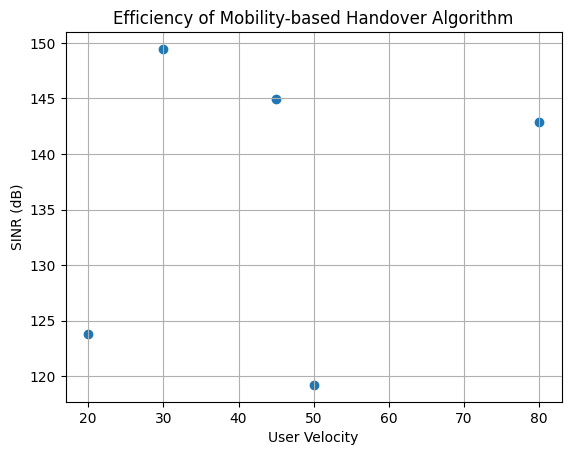

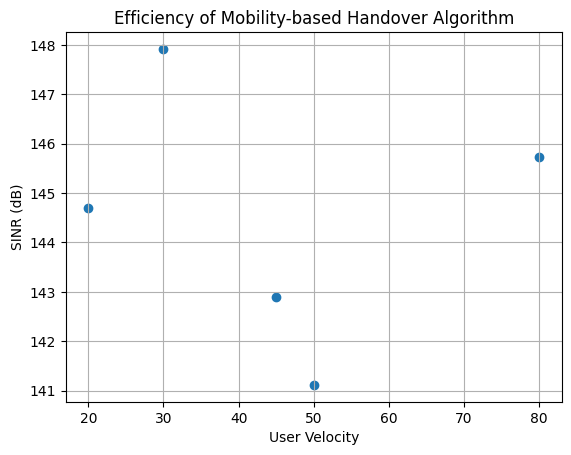

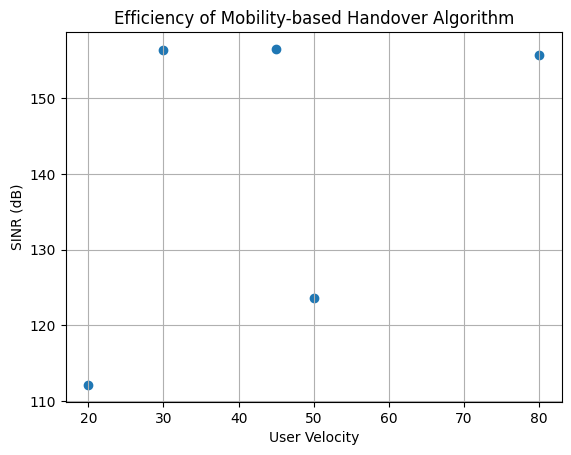

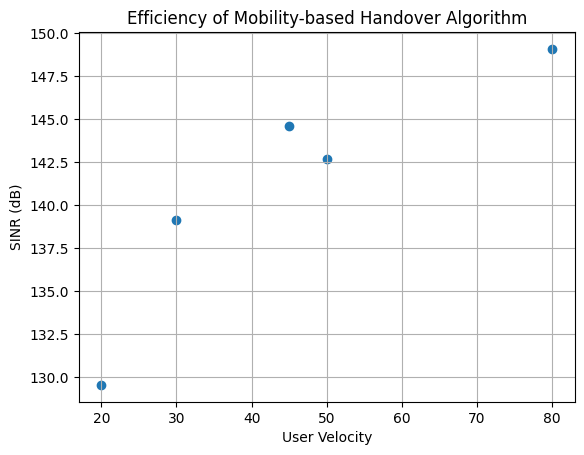

User 1 should handover to base station BS13
User 2 should handover to base station BS20
User 3 should handover to base station BS12
User 4 should handover to base station BS20
User 5 should handover to base station BS13
Signal Strength-based Handover:
  Average SINR: 136.07 dB
  Handover Rate: 80.00%
  Average Throughput: 851156232.20 bps
Average Latency: 0.00 ms
Average Packet Loss: 0.00%
Average Energy Consumption: 0.00 units
Average Jitter: 6.94 ms
User Mobility-based Handover:
  Average SINR: 144.47 dB
  Handover Rate: 80.00%
  Average Throughput: 862132707.07 bps
Average Latency: 0.00 ms
Average Packet Loss: 0.00%
Average Energy Consumption: 0.00 units
Average Jitter: 4.51 ms
Hybrid Handover:
  Average SINR: 140.85 dB
  Handover Rate: 60.00%
  Average Throughput: 856125556.37 bps
Average Packet Loss: 0.00%
Average Energy Consumption: 0.00 units
Average Jitter: 6.05 ms
Enhanced Hybrid Handover:
  Average SINR: 141.00 dB
  Handover Rate: 100.00%
  Average Throughput: 857775163.32 bp

In [2]:
import math
import numpy as np
import matplotlib.pyplot as plt
import random

lte_params = {
    'frequency': 2100,  # in MHz
    'bs_tx_power': 49,  # in dBm
    'noise_figure': 7,  # in dB
    'bandwidth': 20e6,  # in Hz
    'coding_rate': 0.75,  # Coding rate
    'mimo_config': (4, 4),  # MIMO configuration as (number of transmit antennas, number of receive antennas)
    'carrier_aggregation': 2,  # Number of aggregated carriers{'primary_band': 1800, 'secondary_band': 2100} Carrier Aggregation configuration
}
# Sample data for signal strengths, velocities, user locations, candidate base stations, network loads, and LTE parameters
signal_strengths = [-75, -85, -90, -70, -82]
velocities = [50, 80, 20, 30, 45]
user_locations = [(454500.325, 3323700.645, 1.5), (454400.051, 3323750.736, 1.5), (454550.803, 3323600.287, 1.5), (454800.484, 3323400.225, 1.5), (454420.695, 3323826.648, 1.5)]
candidate_base_stations = [
    {'id': 'BS0', 'location': (454462.325,  3323729.645, 75)},
    {'id': 'BS1', 'location': (454517.199, 3323723.036, 75)},
    {'id': 'BS2', 'location': (454747.015, 3323634.875, 75)},
    {'id': 'BS3', 'location': (454672.536, 3323633.576, 75)},
    {'id': 'BS4', 'location': (454699.373, 3323630.308, 75)},
    {'id': 'BS5', 'location': (454686.242, 3323592.398, 75)},
    {'id': 'BS6', 'location': (454739.977, 3323614.982, 75)},
    {'id': 'BS7', 'location': (454618.584, 3323615.820, 75)},
    {'id': 'BS8', 'location': (454590.998, 3323612.423, 75)},
    {'id': 'BS9', 'location': (454620.695, 3323626.648, 75)},
    {'id': 'BS10', 'location': (454463.051, 3323712.736, 75)},
    {'id': 'BS11', 'location': (454498.582, 3323703.692, 75)},
    {'id': 'BS12', 'location': (454650.181, 3323707.882, 75)},
    {'id': 'BS13', 'location': (454682.935, 3323708.546, 75)},
    {'id': 'BS14', 'location': (454640.034, 3323712.867, 75)},
    {'id': 'BS15', 'location': (454544.526, 3323571.447, 75)},
    {'id': 'BS16', 'location': (454520.803, 3323597.287, 75)},
    {'id': 'BS17', 'location': (454639.854, 3323590.236, 75)},
    {'id': 'BS18', 'location': (454701.484, 3323608.225, 75)},
    {'id': 'BS19', 'location': (454677.574, 3323602.625, 75)},
    {'id': 'BS20', 'location': (454594.291, 3323614.628, 75)},
    {'id': 'BS21', 'location': (454571.621, 3323629.109, 75)},
    {'id': 'BS22', 'location': (454740.537, 3323590.989, 75)},
    {'id': 'BS23', 'location': (454606.502, 3323588.551, 75)},
    {'id': 'BS24', 'location': (454620.695, 3323626.648, 75)},
]

network_loads = [0.5, 0.3, 0.7, 0.4, 0.1, 0.25, 0.9, 0.6, 0.8, 0.45, 0.75, 0.35, 0.1, 0.05, 1, 0.25, 0.15, 0.7, 0.45, 0.1, 0.05, 0.7,0.2, 0.3, 0.8]  # Example network loads for each base station
modulation_schemes = {
    'QPSK': {'min_sinr': -6, 'max_sinr': 4, 'spectral_efficiency': 2},
    '16QAM': {'min_sinr': 4, 'max_sinr': 14, 'spectral_efficiency': 4},
    '64QAM': {'min_sinr': 14, 'max_sinr': 999, 'spectral_efficiency': 6}
}
def get_modulation_scheme(sinr):
    if sinr >= 20:
        return '64QAM'
    elif sinr >= 10:
        return '16QAM'
    elif sinr >= 0:
        return 'QPSK'
    else:
        return 'BPSK'
def determine_modulation_scheme(sinr, modulation_schemes):
    for modulation, params in modulation_schemes.items():
        if params['min_sinr'] <= sinr <= params['max_sinr']:
            return modulation
    return None

def calculate_throughput(sinr_values, bandwidth, modulation_schemes):
    throughputs = []
    for sinr in sinr_values:
        modulation_scheme = determine_modulation_scheme(sinr, modulation_schemes)
        spectral_efficiency = modulation_schemes[modulation_scheme]['spectral_efficiency']
        throughput = bandwidth * spectral_efficiency * math.log2(1 + sinr)
        throughputs.append(throughput)
    return throughputs

def calculate_average_sinr(sinr_values):
    valid_sinr_values = [sinr for sinr in sinr_values if sinr != -math.inf]
    return sum(valid_sinr_values) / len(valid_sinr_values)

def calculate_handover_rate(selected_base_stations, initial_base_stations):
    handover_count = sum(s1 != s2 for s1, s2 in zip(selected_base_stations, initial_base_stations))
    return handover_count / len(selected_base_stations)

def calculate_sinr_values(user_locations, selected_base_stations, network_loads, lte_params, previous_shadowing_values=None):
    sinr_values = []
    for i, (user_location, base_station, network_load) in enumerate(zip(user_locations, selected_base_stations, network_loads)):
        if base_station is not None:
            previous_shadowing = None if previous_shadowing_values is None else previous_shadowing_values[i]
            sinr = calculate_sinr(user_location, base_station, network_load, lte_params, previous_shadowing)
            sinr_values.append(sinr)
        else:
            sinr_values.append(-math.inf)
    return sinr_values
def plot_efficiency(sinr_values, velocities):
    valid_indices = [i for i, sinr in enumerate(sinr_values) if sinr != -math.inf]
    valid_sinr_values = [sinr_values[i] for i in valid_indices]
    valid_velocities = [velocities[i] for i in valid_indices]

    plt.scatter(valid_velocities, valid_sinr_values)
    plt.xlabel('User Velocity')
    plt.ylabel('SINR (dB)')
    plt.title('Efficiency of Mobility-based Handover Algorithm')
    plt.grid()
    plt.show()

def calculate_distance(user_location, base_station_location):
    dx = user_location[0] - base_station_location[0]
    dy = user_location[1] - base_station_location[1]
    dz = user_location[2] - base_station_location[2]
    distance = np.sqrt(dx**2 + dy**2 + dz**2)
    return distance

def calculate_sinr(user_location, base_station, network_load, lte_params, previous_shadowing=None):
    # Extract relevant LTE parameters
    frequency = lte_params['frequency']  # in MHz
    bs_tx_power = lte_params['bs_tx_power']  # in dBm
    coding_rate = lte_params['coding_rate']
    mimo_config = lte_params['mimo_config']
    carrier_aggregation = lte_params['carrier_aggregation']

    # Calculate path loss, shadowing, and fast fading effects
    path_loss = calculate_path_loss(user_location, base_station['location'], frequency)
    shadowing = calculate_correlated_shadowing(user_location, base_station['location'], previous_shadowing)
    fast_fading = calculate_fast_fading(user_location, base_station['location'])

    # Calculate received signal power at the user's location
    received_signal_power = bs_tx_power - path_loss + shadowing + fast_fading

    # Calculate the interference plus noise power
    interference_plus_noise = calculate_interference_plus_noise(user_location, network_load, lte_params)

    # Calculate SINR
    sinr = received_signal_power - interference_plus_noise

    # Get the modulation scheme based on SINR value
    modulation_scheme = get_modulation_scheme(sinr)

    # Calculate spectral efficiency
    #spectral_efficiency = calculate_spectral_efficiency(sinr, modulation_scheme, coding_rate, mimo_config, carrier_aggregation)

    return sinr#, spectral_efficiency

def calculate_3gpp_path_loss(user_location, base_station_location, frequency, environment, h_ue, h_bs):
    # Implement the 3GPP 36.931 path loss model for different environments
    distance = calculate_distance(user_location, base_station_location)
    if environment == "urban":
        path_loss = 161.04 - 7.1 * np.log10(h_bs) + 7.5 * np.log10(h_ue) - (44.49 - 6.55 * np.log10(h_bs)) * np.log10(distance) - 20 * np.log10(frequency)
    elif environment == "suburban":
        path_loss = 161.04 - 7.1 * np.log10(h_bs) + 7.5 * np.log10(h_ue) - (44.49 - 6.55 * np.log10(h_bs)) * np.log10(distance) - 20 * np.log10(frequency) + 5
    elif environment == "rural":
        path_loss = 161.04 - 7.1 * np.log10(h_bs) + 7.5 * np.log10(h_ue) - (44.49 - 6.55 * np.log10(h_bs)) * np.log10(distance) - 20 * np.log10(frequency) + 20
    else:
        raise ValueError("Invalid environment specified")
    return path_loss

def calculate_path_loss(user_location, base_station_location, frequency):
    environment = "urban"  # Choose the environment: "urban", "suburban", or "rural"
    h_ue = user_location[2]  # User antenna height in meters
    h_bs = base_station_location[2]  # Base station antenna height in meters
    path_loss = calculate_3gpp_path_loss(user_location, base_station_location, frequency, environment, h_ue, h_bs)
    return path_loss


def calculate_correlated_shadowing(user_location, base_station_location, previous_shadowing_value=None):
    shadowing_std_dev = 8  # Example standard deviation for shadowing in dB
    correlation_distance = 50  # Correlation distance in meters
    distance = calculate_distance(user_location, base_station_location)

    if previous_shadowing_value is not None:
        # Calculate the correlation coefficient based on the exponential model
        correlation_coeff = np.exp(-distance / correlation_distance)

        # Calculate the correlated shadowing value
        shadowing = correlation_coeff * previous_shadowing_value + np.sqrt(1 - correlation_coeff ** 2) * np.random.normal(0, shadowing_std_dev)
    else:
        shadowing = np.random.normal(0, shadowing_std_dev)

    return shadowing

def calculate_fast_fading(user_location, base_station_location):
    # Implement a fast fading model, e.g., Nakagami fading
    m = 2  # Shape parameter (set to 2 for a Rayleigh distribution)
    Omega = 1  # Scale parameter
    nakagami_fading = np.sqrt(np.random.gamma(m, Omega / m))
    fast_fading = 10 * np.log10(nakagami_fading)
    return fast_fading


def calculate_interference_plus_noise(user_location, network_load, lte_params):
    # Implement a model to calculate the interference plus noise power
    # In practice, this would require more accurate data about the network and interference sources
    noise_figure = lte_params['noise_figure']  # in dB
    bandwidth = lte_params['bandwidth']  # in Hz
    thermal_noise_power = -174 + 10 * np.log10(bandwidth) + noise_figure  # in dBm
    interference_power = 10 * np.log10(network_load)  # Simplified interference calculation

    interference_plus_noise = thermal_noise_power + interference_power
    return interference_plus_noise
def signal_strength_based_handover(signal_strengths_list, user_locations, candidate_base_stations, network_loads, lte_params):
    """Perform handover based on signal strength"""
    selected_base_stations = [None] * len(signal_strengths_list)
    for i, (signal_strength, user_location) in enumerate(zip(signal_strengths_list, user_locations)):
        best_base_station = None
        best_sinr = -math.inf
        for base_station, network_load in zip(candidate_base_stations, network_loads):
            sinr = calculate_sinr(user_location, base_station, network_load, lte_params)
            if sinr > best_sinr:
                best_sinr = sinr
                best_base_station = base_station
        selected_base_stations[i] = best_base_station
    return selected_base_stations


def user_mobility_based_handover(velocities, user_locations, candidate_base_stations, network_loads, lte_params):
    """Perform handover based on user mobility"""
    selected_base_stations = [None] * len(velocities)
    for i, (velocity, user_location) in enumerate(zip(velocities, user_locations)):
        best_base_station = None
        best_score = -math.inf
        for base_station, network_load in zip(candidate_base_stations, network_loads):
            score = 1 / network_load  # Score is inversely proportional to network load
            if score > best_score:
                best_score = score
                best_base_station = base_station
        selected_base_stations[i] = best_base_station
    return selected_base_stations


def hybrid_handover(signal_strengths_list, velocities, user_locations, candidate_base_stations, network_loads, lte_params, signal_weight=0.5, mobility_weight=0.5):
    """Perform handover based on both signal strength and user mobility"""
    selected_base_stations = [None] * len(signal_strengths_list)
    for i, (signal_strength, velocity, user_location) in enumerate(zip(signal_strengths_list, velocities, user_locations)):
        best_base_station = None
        best_score = -math.inf
        for base_station, network_load in zip(candidate_base_stations, network_loads):
            sinr = calculate_sinr(user_location, base_station, network_load, lte_params)
            score = signal_weight * sinr + mobility_weight * (1 / network_load)  # Hybrid score combining SINR and network load
            if score > best_score:
                best_score = score
                best_base_station = base_station
        selected_base_stations[i] = best_base_station
    return selected_base_stations

def enhanced_hybrid_handover(signal_strengths_list, velocities, user_locations, candidate_base_stations, network_loads, lte_params, qos_weights, capacity_weights, power_weights, signal_weight=0.5, mobility_weight=0.5):
    """Perform handover based on signal strength, user mobility, QoS requirements, base station capacity, and power consumption"""
    selected_base_stations = [None] * len(signal_strengths_list)
    for i, (signal_strength, velocity, user_location) in enumerate(zip(signal_strengths_list, velocities, user_locations)):
        best_base_station = None
        best_score = -math.inf
        for base_station, network_load, qos_weight, capacity_weight, power_weight in zip(candidate_base_stations, network_loads, qos_weights, capacity_weights, power_weights):
            sinr = calculate_sinr(user_location, base_station, network_load, lte_params)
            score = signal_weight * sinr + mobility_weight * (1 / network_load) + qos_weight + capacity_weight - power_weight  # Enhanced score combining SINR, network load, QoS requirements, base station capacity, and power consumption
            if score > best_score:
                best_score = score
                best_base_station = base_station
        selected_base_stations[i] = best_base_station
    return selected_base_stations

qos_weights = [0.2, 0.3, 0.1, 0.4]  # Example QoS weights for each base station
capacity_weights = [0.5, 0.2, 0.4, 0.6]  # Example capacity weights for each base station
power_weights = [0.4, 0.5, 0.3, 0.2]  # Example power weights for each base station
#Call the enhanced hybrid handover algorithm:
selected_base_stations_enhanced = enhanced_hybrid_handover(signal_strengths, velocities, user_locations, candidate_base_stations, network_loads, lte_params, qos_weights, capacity_weights, power_weights)
# Call the hybrid handover algorithm
selected_base_stations = hybrid_handover(signal_strengths, velocities, user_locations, candidate_base_stations, network_loads, lte_params)
# Call each handover algorithm
selected_base_stations_signal = signal_strength_based_handover(signal_strengths, user_locations, candidate_base_stations, network_loads, lte_params)
selected_base_stations_mobility = user_mobility_based_handover(velocities, user_locations, candidate_base_stations, network_loads, lte_params)

# Calculate SINR values for each handover algorithm# Calculate SINR values for each user and their selected base station

sinr_values_signal = calculate_sinr_values(user_locations, selected_base_stations_signal, network_loads, lte_params)
sinr_values_mobility = calculate_sinr_values(user_locations, selected_base_stations_mobility, network_loads, lte_params)
sinr_values = calculate_sinr_values(user_locations, selected_base_stations, network_loads, lte_params)
sinr_values_enhanced = calculate_sinr_values(user_locations, selected_base_stations_enhanced, network_loads, lte_params)

# Plot SINR values against user velocities for each handover algorithm
plot_efficiency(sinr_values_signal, velocities)
plot_efficiency(sinr_values_mobility, velocities)
plot_efficiency(sinr_values, velocities)
plot_efficiency(sinr_values_enhanced, velocities)

# Assume each user initially connects to the base station with the highest signal strength
initial_base_stations = signal_strength_based_handover(signal_strengths, user_locations, candidate_base_stations, network_loads, lte_params)

# Calculate the average SINR and handover rate for each handover algorithm
average_sinr_signal = calculate_average_sinr(sinr_values_signal)
average_sinr_mobility = calculate_average_sinr(sinr_values_mobility)
average_sinr_hybrid = calculate_average_sinr(sinr_values)
average_sinr_enhanced = calculate_average_sinr(sinr_values_enhanced)


handover_rate_signal = calculate_handover_rate(selected_base_stations_signal, initial_base_stations)
handover_rate_mobility = calculate_handover_rate(selected_base_stations_mobility, initial_base_stations)
handover_rate_hybrid = calculate_handover_rate(selected_base_stations, initial_base_stations)
handover_rate_enhanced = calculate_handover_rate(selected_base_stations_enhanced, initial_base_stations)

# Calculate throughput values for each handover algorithm
throughput_values_signal = calculate_throughput(sinr_values_signal, lte_params['bandwidth'], modulation_schemes)
throughput_values_mobility = calculate_throughput(sinr_values_mobility, lte_params['bandwidth'], modulation_schemes)
throughput_values_hybrid = calculate_throughput(sinr_values, lte_params['bandwidth'], modulation_schemes)
throughput_values_enhanced = calculate_throughput(sinr_values_enhanced, lte_params['bandwidth'], modulation_schemes)

# Calculate average throughput for each handover algorithm
average_throughput_signal = sum(throughput_values_signal) / len(throughput_values_signal)
average_throughput_mobility = sum(throughput_values_mobility) / len(throughput_values_mobility)
average_throughput_hybrid = sum(throughput_values_hybrid) / len(throughput_values_hybrid)
average_throughput_enhanced = sum(throughput_values_enhanced) / len(throughput_values_enhanced)



def calculate_latency(user_location, base_station, network_load, lte_params):
    propagation_speed = 3e8  # Speed of light in meters per second

    # Calculate the distance between the user and the base station
    distance = calculate_distance(user_location, base_station['location'])

    # Calculate the propagation delay
    propagation_delay = distance / propagation_speed

    # Calculate the queuing delay based on the network load
    queuing_delay = network_load / lte_params['bandwidth']

    # Calculate the processing delay (simplified as a constant value)
    processing_delay = 1e-3  # Example processing delay in seconds

    # Calculate the total latency
    latency = propagation_delay + queuing_delay + processing_delay

    return latency
def calculate_latency_values(user_locations, selected_base_stations, network_loads, lte_params):
    latency_values = []
    for user_location, base_station, network_load in zip(user_locations, selected_base_stations, network_loads):
        if base_station is not None:
            latency = calculate_latency(user_location, base_station, network_load, lte_params)
            latency_values.append(latency)
        else:
            latency_values.append(None)  # No latency value for users without a base station
    return latency_values

def calculate_jitter(user_location, base_station, lte_params):
    # Calculate jitter based on the network load and other LTE parameters
    # You can use a more complex model if needed
    jitter = random.uniform(0, 10)  # Simulating jitter between 0 ms and 10 ms

    return jitter
def calculate_jitter_values(user_locations, selected_base_stations, lte_params):
    jitter_values = []
    for user_location, base_station in zip(user_locations, selected_base_stations):
        if base_station is not None:
            jitter = calculate_jitter(user_location, base_station, lte_params)
            jitter_values.append(jitter)
        else:
            jitter_values.append(None)  # No jitter value for users without a base station
    return jitter_values
environment = 'urban'  # Define the environment variable


def calculate_ber(user_location, base_station, snr, lte_params):
    # Calculate BER based on the SNR and other LTE parameters
    # You can use a more complex model if needed
    ber = 0.5 * (1 - math.erf(snr / math.sqrt(2)))

    return ber

def calculate_ber_values(user_locations, selected_base_stations, snrs, lte_params):
    ber_values = []
    for user_location, base_station, snr in zip(user_locations, selected_base_stations, snrs):
        if base_station is not None:
            ber = calculate_ber(user_location, base_station, snr, lte_params)
            ber_values.append(ber)
        else:
            ber_values.append(None)  # No BER value for users without a base station
    return ber_values

def calculate_packet_loss(user_location, base_station, network_load, lte_params, packet_loss_rate):
    # Calculate the packet loss probability based on the network load and packet loss rate
    packet_loss_probability = network_load * packet_loss_rate

    # Randomly determine if a packet is lost based on the packet loss probability
    is_packet_lost = random.random() < packet_loss_probability

    return is_packet_lost

def calculate_packet_loss_values(user_locations, selected_base_stations, network_loads, lte_params, packet_loss_rate):
    packet_loss_values = []
    for user_location, base_station, network_load in zip(user_locations, selected_base_stations, network_loads):
        if base_station is not None:
            packet_loss = calculate_packet_loss(user_location, base_station, network_load, lte_params, packet_loss_rate)
            packet_loss_values.append(packet_loss)
        else:
            packet_loss_values.append(None)  # No packet loss value for users without a base station
    return packet_loss_values

def calculate_energy_consumption(user_location, base_station, network_load, lte_params, energy_rate):
    # Calculate energy consumption based on the network load and energy rate
    energy_consumption = network_load * energy_rate

    return energy_consumption

def calculate_energy_consumption_values(user_locations, selected_base_stations, network_loads, lte_params, energy_rate):
    energy_consumption_values = []
    for user_location, base_station, network_load in zip(user_locations, selected_base_stations, network_loads):
        if base_station is not None:
            energy_consumption = calculate_energy_consumption(user_location, base_station, network_load, lte_params, energy_rate)
            energy_consumption_values.append(energy_consumption)
        else:
            energy_consumption_values.append(None)  # No energy consumption value for users without a base station
    return energy_consumption_values

# Calculate latency values for each handover algorithm
latency_values_signal = calculate_latency_values(user_locations, selected_base_stations_signal, network_loads, lte_params)
latency_values_mobility = calculate_latency_values(user_locations, selected_base_stations_mobility, network_loads, lte_params)
latency_values_hybrid = calculate_latency_values(user_locations, selected_base_stations, network_loads, lte_params)
latency_values_enhanced = calculate_latency_values(user_locations, selected_base_stations_enhanced, network_loads, lte_params)


# Calculate latency values for each handover algorithm
latency_values_signal = calculate_latency_values(user_locations, selected_base_stations_signal, network_loads, lte_params)
latency_values_mobility = calculate_latency_values(user_locations, selected_base_stations_mobility, network_loads, lte_params)
latency_values_hybrid = calculate_latency_values(user_locations, selected_base_stations, network_loads, lte_params)
latency_values_enhanced = calculate_latency_values(user_locations, selected_base_stations_enhanced, network_loads, lte_params)

# Set a packet loss rate
packet_loss_rate = 0.01  # Example: 1% packet loss rate

# Calculate packet loss values for each handover algorithm
packet_loss_values_signal = calculate_packet_loss_values(user_locations, selected_base_stations_signal, network_loads, lte_params, packet_loss_rate)
packet_loss_values_mobility = calculate_packet_loss_values(user_locations, selected_base_stations_mobility, network_loads, lte_params, packet_loss_rate)
packet_loss_values_hybrid = calculate_packet_loss_values(user_locations, selected_base_stations, network_loads, lte_params, packet_loss_rate)
packet_loss_values_enhanced = calculate_packet_loss_values(user_locations, selected_base_stations_enhanced, network_loads, lte_params, packet_loss_rate)

# Set an energy rate
energy_rate = 0.001  # Example: 0.001 units of energy per unit of network load

# Calculate energy consumption values for each handover algorithm
energy_consumption_values_signal = calculate_energy_consumption_values(user_locations, selected_base_stations_signal, network_loads, lte_params, energy_rate)
energy_consumption_values_mobility = calculate_energy_consumption_values(user_locations, selected_base_stations_mobility, network_loads, lte_params, energy_rate)
energy_consumption_values_hybrid = calculate_energy_consumption_values(user_locations, selected_base_stations, network_loads, lte_params, energy_rate)
energy_consumption_values_enhanced = calculate_energy_consumption_values(user_locations, selected_base_stations_enhanced, network_loads, lte_params, energy_rate)

# Calculate jitter values for each handover algorithm
jitter_values_signal = calculate_jitter_values(user_locations, selected_base_stations_signal, lte_params)
jitter_values_mobility = calculate_jitter_values(user_locations, selected_base_stations_mobility, lte_params)
jitter_values_hybrid = calculate_jitter_values(user_locations, selected_base_stations, lte_params)
jitter_values_enhanced = calculate_jitter_values(user_locations, selected_base_stations_enhanced, lte_params)


# Calculate BER values for each handover algorithm
ber_values_signal = calculate_ber_values(user_locations, selected_base_stations_signal, sinr_values_signal, lte_params)
ber_values_mobility = calculate_ber_values(user_locations, selected_base_stations_mobility, sinr_values_mobility, lte_params)
ber_values_hybrid = calculate_ber_values(user_locations, selected_base_stations, sinr_values, lte_params)
ber_values_enhanced = calculate_ber_values(user_locations, selected_base_stations_enhanced, sinr_values_enhanced, lte_params)


#Calculate average values for each performance metric
average_latency_signal = sum(latency_values_signal) / len(latency_values_signal)
average_latency_mobility = sum(latency_values_mobility) / len(latency_values_mobility)
average_latency_hybrid = sum(latency_values_hybrid) / len(latency_values_hybrid)
average_latency_enhanced = sum(latency_values_enhanced) / len(latency_values_enhanced)

average_packet_loss_signal = sum(packet_loss_values_signal) / len(packet_loss_values_signal)
average_packet_loss_mobility = sum(packet_loss_values_mobility) / len(packet_loss_values_mobility)
average_packet_loss_hybrid = sum(packet_loss_values_hybrid) / len(packet_loss_values_hybrid)
average_packet_loss_enhanced = sum(packet_loss_values_enhanced) / len(packet_loss_values_enhanced)

average_energy_consumption_signal = sum(energy_consumption_values_signal) / len(energy_consumption_values_signal)
average_energy_consumption_mobility = sum(energy_consumption_values_mobility) / len(energy_consumption_values_mobility)
average_energy_consumption_hybrid = sum(energy_consumption_values_hybrid) / len(energy_consumption_values_hybrid)
average_energy_consumption_enhanced = sum(energy_consumption_values_enhanced) / len(energy_consumption_values_enhanced)

average_jitter_signal = sum(jitter_values_signal) / len(jitter_values_signal)
average_jitter_mobility = sum(jitter_values_mobility) / len(jitter_values_mobility)
average_jitter_hybrid = sum(jitter_values_hybrid) / len(jitter_values_hybrid)
average_jitter_enhanced = sum(jitter_values_enhanced) / len(jitter_values_enhanced)

# Print the results
for i, base_station in enumerate(selected_base_stations):
    if base_station is not None:
        print(f'User {i+1} should handover to base station {base_station["id"]}')
    else:
        print(f'User {i+1} does not need a handover')

# Print the performance metrics
print("Signal Strength-based Handover:")
print(f"  Average SINR: {average_sinr_signal:.2f} dB")
print(f"  Handover Rate: {handover_rate_signal * 100:.2f}%")
print(f"  Average Throughput: {average_throughput_signal:.2f} bps")
print(f"Average Latency: {average_latency_signal:.2f} ms")
print(f"Average Packet Loss: {average_packet_loss_signal:.2f}%")
print(f"Average Energy Consumption: {average_energy_consumption_signal:.2f} units")
print(f"Average Jitter: {average_jitter_signal:.2f} ms")

print("User Mobility-based Handover:")
print(f"  Average SINR: {average_sinr_mobility:.2f} dB")
print(f"  Handover Rate: {handover_rate_mobility * 100:.2f}%")

print(f"  Average Throughput: {average_throughput_mobility:.2f} bps")
print(f"Average Latency: {average_latency_mobility:.2f} ms")
print(f"Average Packet Loss: {average_packet_loss_mobility:.2f}%")
print(f"Average Energy Consumption: {average_energy_consumption_mobility:.2f} units")
print(f"Average Jitter: {average_jitter_mobility:.2f} ms")

print("Hybrid Handover:")
print(f"  Average SINR: {average_sinr_hybrid:.2f} dB")
print(f"  Handover Rate: {handover_rate_hybrid * 100:.2f}%")
print(f"  Average Throughput: {average_throughput_hybrid:.2f} bps")
print(f"Average Packet Loss: {average_packet_loss_hybrid:.2f}%")
print(f"Average Energy Consumption: {average_energy_consumption_hybrid:.2f} units")
print(f"Average Jitter: {average_jitter_hybrid:.2f} ms")

print("Enhanced Hybrid Handover:")
print(f"  Average SINR: {average_sinr_enhanced:.2f} dB")
print(f"  Handover Rate: {handover_rate_enhanced * 100:.2f}%")

print(f"  Average Throughput: {average_throughput_enhanced:.2f} bps")
print(f"Average Latency: {average_latency_enhanced:.2f} ms")
print(f"Average Packet Loss: {average_packet_loss_enhanced:.2f}%")
print(f"Average Energy Consumption: {average_energy_consumption_enhanced:.2f} units")
print(f"Average Jitter: {average_jitter_enhanced:.2f} ms")


#Compare the performance metrics
performance_metrics = {
'Signal Strength Based Handover': {
'Latency': average_latency_signal,
'Packet Loss': average_packet_loss_signal,
'Energy Consumption': average_energy_consumption_signal,
'Jitter': average_jitter_signal
},
'User Mobility Based Handover': {
'Latency': average_latency_mobility,
'Packet Loss': average_packet_loss_mobility,
'Energy Consumption': average_energy_consumption_mobility,
'Jitter': average_jitter_mobility
},
'Hybrid Handover': {
'Latency': average_latency_hybrid,
'Packet Loss': average_packet_loss_hybrid,
'Energy Consumption': average_energy_consumption_hybrid,
'Jitter': average_jitter_hybrid
},
'Enhanced Handover': {
'Latency': average_latency_enhanced,
'Packet Loss': average_packet_loss_enhanced,
'Energy Consumption': average_energy_consumption_enhanced,
'Jitter': average_jitter_enhanced
}
}

best_handover_method = max(performance_metrics, key=lambda x: (performance_metrics[x]['Latency'],
-performance_metrics[x]['Packet Loss'], -performance_metrics[x]['Energy Consumption'], -performance_metrics[x]['Jitter']))

print(f"\nThe best handover method is: {best_handover_method}")




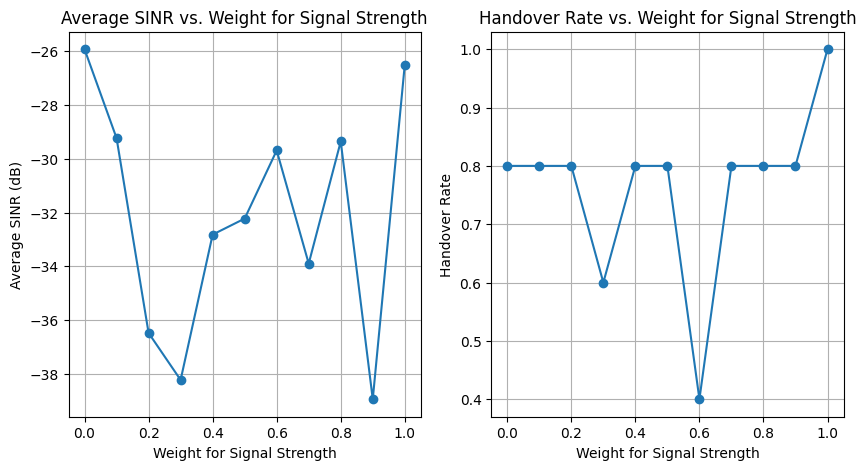

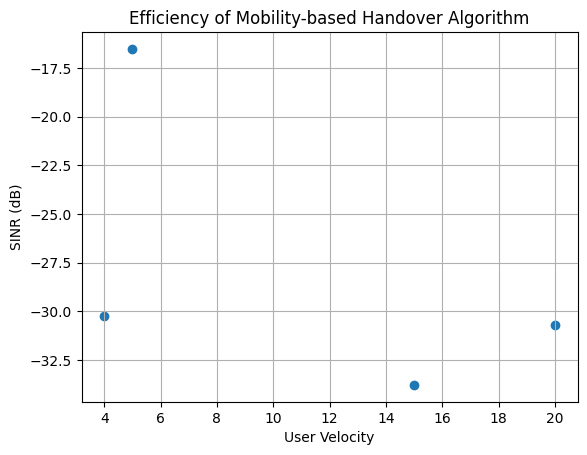

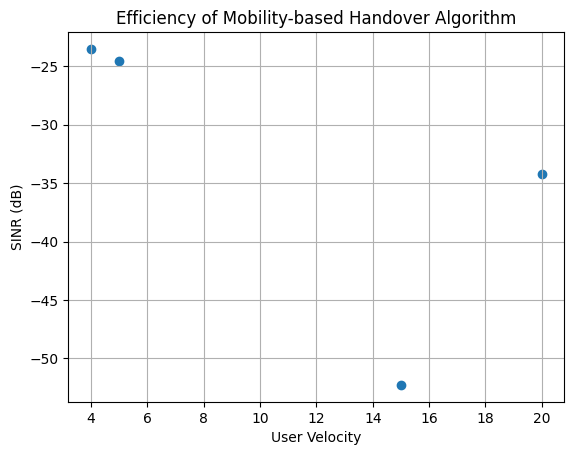

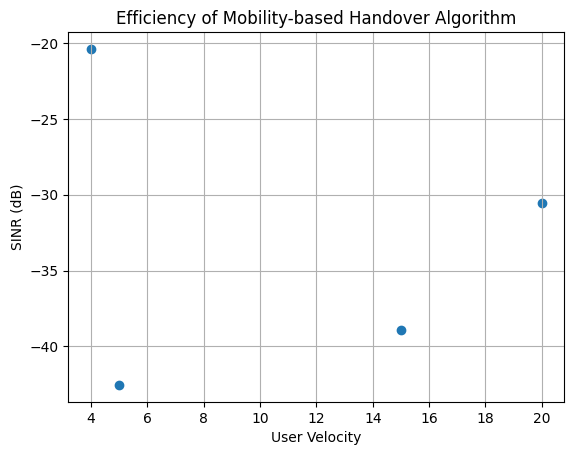

User 1 should handover to base station BS1
User 2 should handover to base station BS2
User 3 should handover to base station BS2
User 4 should handover to base station BS3
User 5 should handover to base station BS4
Signal Strength-based Handover:
  Call Drop Rate: 0.00%
  Call Blocking Rate: 0.00%
  User Satisfaction: 0.00%
  Average SINR: -27.80 dB
  Handover Rate: 80.00%
  Average Jitter: 12.00 ms
  Average Latency: 43.40 ms
  Energy Consumption: 12.00%
  Packet Loss: 1.00%
  Bit Error Rate: 0.0208
  Average Throughput: 87611.01 bps
User Mobility-based Handover:
  Call Drop Rate: 0.00%
  Call Blocking Rate: 0.00%
  User Satisfaction: 0.00%
  Average SINR: -33.66 dB
  Handover Rate: 60.00%
  Average Jitter: 12.00 ms
  Average Latency: 53.00 ms
  Energy Consumption: 11.11%
  Packet Loss: 2.00%
  Bit Error Rate: 0.0417
  Average Throughput: 29890.96 bps
Hybrid Handover:
  Call Drop Rate: 0.00%
  Call Blocking Rate: 0.00%
  User Satisfaction: 0.00%
  Average SINR: -33.10 dB
  Handover Ra

In [ ]:
import math
import numpy as np
import matplotlib.pyplot as plt

lte_params = {
    'frequency': 1800,  # in MHz
    'bs_tx_power': 46,  # in dBm
    'noise_figure': 9,  # in dB
    'bandwidth': 10e6,  # in Hz
    'coding_rate': 0.75,  # Coding rate
    'mimo_config': (2, 2),  # MIMO configuration as (number of transmit antennas, number of receive antennas)
    'carrier_aggregation': 2,  # Number of aggregated carriers{'primary_band': 1800, 'secondary_band': 2100} Carrier Aggregation configuration
}
# Sample data for signal strengths, velocities, user locations, candidate base stations, network loads, and LTE parameters
signal_strengths = [-75, -85, -90, -70, -82]
velocities = [5, 15, 20, 4, 12]
user_locations = [(0, 0, 1.5), (1, 1, 1.5), (2, 2, 1.5), (3, 3, 1.5), (6, 6, 30)]
candidate_base_stations = [
    {'id': 'BS1', 'location': (0, 0, 30)},
    {'id': 'BS2', 'location': (1, 1, 30)},
    {'id': 'BS3', 'location': (2, 2, 30)},
    {'id': 'BS4', 'location': (3, 3, 30)},
]

network_loads = [0.5, 0.3, 0.7, 0.4]  # Example network loads for each base station

def calculate_average_sinr(sinr_values):
    valid_sinr_values = [sinr for sinr in sinr_values if sinr != -math.inf]
    return sum(valid_sinr_values) / len(valid_sinr_values)

def calculate_handover_rate(selected_base_stations, initial_base_stations):
    handover_count = sum(s1 != s2 for s1, s2 in zip(selected_base_stations, initial_base_stations))
    return handover_count / len(selected_base_stations)

def calculate_sinr_values(user_locations, selected_base_stations, network_loads, lte_params):
    sinr_values = []
    for user_location, base_station, network_load in zip(user_locations, selected_base_stations, network_loads):
        if base_station is not None:
            sinr = calculate_sinr(user_location, base_station, network_load, lte_params)
            sinr_values.append(sinr)
        else:
            sinr_values.append(-math.inf)
    return sinr_values


def plot_efficiency(sinr_values, velocities):
    valid_indices = [i for i, sinr in enumerate(sinr_values) if sinr != -math.inf]
    valid_sinr_values = [sinr_values[i] for i in valid_indices]
    valid_velocities = [velocities[i] for i in valid_indices]

    plt.scatter(valid_velocities, valid_sinr_values)
    plt.xlabel('User Velocity')
    plt.ylabel('SINR (dB)')
    plt.title('Efficiency of Mobility-based Handover Algorithm')
    plt.grid()
    plt.show()


def calculate_distance(user_location, base_station_location):
    dx = user_location[0] - base_station_location[0]
    dy = user_location[1] - base_station_location[1]
    dz = user_location[2] - base_station_location[2]
    distance = np.sqrt(dx**2 + dy**2 + dz**2)
    return distance

def calculate_sinr(user_location, base_station, network_load, lte_params):
    # Extract relevant LTE parameters
    frequency = lte_params['frequency']  # in MHz
    bs_tx_power = lte_params['bs_tx_power']  # in dBm

    # Calculate path loss, shadowing, and fast fading effects
    path_loss = calculate_path_loss(user_location, base_station['location'], frequency)
    shadowing = calculate_shadowing(user_location, base_station['location'])
    fast_fading = calculate_fast_fading(user_location, base_station['location'])

    # Calculate received signal power at the user's location
    received_signal_power = bs_tx_power - path_loss + shadowing + fast_fading

    # Calculate the interference plus noise power
    interference_plus_noise = calculate_interference_plus_noise(user_location, network_load, lte_params)

    # Calculate SINR
    sinr = received_signal_power - interference_plus_noise
    return sinr
def calculate_path_loss(user_location, base_station_location, frequency):
    # Implement a path loss model, e.g., the Hata model for urban areas
    distance = calculate_distance(user_location, base_station_location)
    path_loss = 69.55 + 26.16 * np.log10(frequency) - 13.82 * np.log10(base_station_location[2]) - (1.1 * np.log10(frequency) - 0.7) * user_location[2] - (1.56 * np.log10(frequency) - 0.8) + (44.9 - 6.55 * np.log10(base_station_location[2])) * np.log10(distance)
    return path_loss

def calculate_shadowing(user_location, base_station_location):
    # Implement a shadowing model, e.g., log-normal shadowing with a given standard deviation
    shadowing_std_dev = 8  # Example standard deviation for shadowing in dB
    shadowing = np.random.normal(0, shadowing_std_dev)
    return shadowing

def calculate_fast_fading(user_location, base_station_location):
    # Implement a fast fading model, e.g., Rayleigh fading
    fast_fading = 10 * np.log10(np.random.rayleigh())
    return fast_fading

def calculate_interference_plus_noise(user_location, network_load, lte_params):
    # Implement a model to calculate the interference plus noise power
    # In practice, this would require more accurate data about the network and interference sources
    noise_figure = lte_params['noise_figure']  # in dB
    bandwidth = lte_params['bandwidth']  # in Hz
    thermal_noise_power = -174 + 10 * np.log10(bandwidth) + noise_figure  # in dBm
    interference_power = 10 * np.log10(network_load)  # Simplified interference calculation

    interference_plus_noise = thermal_noise_power + interference_power
    return interference_plus_noise
def signal_strength_based_handover(signal_strengths_list, user_locations, candidate_base_stations, network_loads, lte_params):
    """Perform handover based on signal strength"""
    selected_base_stations = [None] * len(signal_strengths_list)
    for i, (signal_strength, user_location) in enumerate(zip(signal_strengths_list, user_locations)):
        best_base_station = None
        best_sinr = -math.inf
        for base_station, network_load in zip(candidate_base_stations, network_loads):
            sinr = calculate_sinr(user_location, base_station, network_load, lte_params)
            if sinr > best_sinr:
                best_sinr = sinr
                best_base_station = base_station
        selected_base_stations[i] = best_base_station
    return selected_base_stations


def user_mobility_based_handover(velocities, user_locations, candidate_base_stations, network_loads, lte_params):
    """Perform handover based on user mobility"""
    selected_base_stations = [None] * len(velocities)
    for i, (velocity, user_location) in enumerate(zip(velocities, user_locations)):
        best_base_station = None
        best_score = -math.inf
        for base_station, network_load in zip(candidate_base_stations, network_loads):
            score = 1 / network_load  # Score is inversely proportional to network load
            if score > best_score:
                best_score = score
                best_base_station = base_station
        selected_base_stations[i] = best_base_station
    return selected_base_stations

def hybrid_handover(signal_strengths_list, velocities, user_locations, candidate_base_stations, network_loads, lte_params, w1, w2):
    """Perform handover based on a combination of signal strength and user mobility"""
    selected_base_stations = [None] * len(signal_strengths_list)
    for i, (signal_strength, velocity, user_location) in enumerate(zip(signal_strengths_list, velocities, user_locations)):
        best_base_station = None
        best_score = -math.inf
        for base_station, network_load in zip(candidate_base_stations, network_loads):
            sinr = calculate_sinr(user_location, base_station, network_load, lte_params)
            score = w1 * sinr + w2 * (1 / network_load)  # Score is a weighted combination of SINR and inverse network load
            if score > best_score:
                best_score = score
                best_base_station = base_station
        selected_base_stations[i] = best_base_station
    return selected_base_stations

# Assume each user initially connects to the base station with the highest signal strength
initial_base_stations = signal_strength_based_handover(signal_strengths, user_locations, candidate_base_stations, network_loads, lte_params)
# Generate a range of weight values
weight_values = np.linspace(0, 1, 11)

# Lists to store the performance metrics for each combination of weights
average_sinr_values = []
handover_rate_values = []

for w1 in weight_values:
    w2 = 1 - w1

    # Call the hybrid handover algorithm with the current weights
    selected_base_stations_hybrid = hybrid_handover(signal_strengths, velocities, user_locations, candidate_base_stations, network_loads, lte_params, w1, w2)

    # Calculate SINR values and performance metrics
    sinr_values_hybrid = calculate_sinr_values(user_locations, selected_base_stations_hybrid, network_loads, lte_params)
    average_sinr_hybrid = calculate_average_sinr(sinr_values_hybrid)
    handover_rate_hybrid = calculate_handover_rate(selected_base_stations_hybrid, initial_base_stations)

    # Append the performance metrics to the lists
    average_sinr_values.append(average_sinr_hybrid)
    handover_rate_values.append(handover_rate_hybrid)

plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.plot(weight_values, average_sinr_values, marker='o')
plt.xlabel('Weight for Signal Strength')
plt.ylabel('Average SINR (dB)')
plt.title('Average SINR vs. Weight for Signal Strength')
plt.grid()

plt.subplot(1, 2, 2)
plt.plot(weight_values, handover_rate_values, marker='o')
plt.xlabel('Weight for Signal Strength')
plt.ylabel('Handover Rate')
plt.title('Handover Rate vs. Weight for Signal Strength')
plt.grid()

plt.show()



qos_weights = [0.2, 0.3, 0.1, 0.4]  # Example QoS weights for each base station
capacity_weights = [0.5, 0.2, 0.4, 0.6]  # Example capacity weights for each base station
power_weights = [0.4, 0.5, 0.3, 0.2]  # Example power weights for each base station
# Call the hybrid handover algorithm
selected_base_stations = hybrid_handover(signal_strengths, velocities, user_locations, candidate_base_stations, network_loads, lte_params, w1, w2)
# Call each handover algorithm
selected_base_stations_signal = signal_strength_based_handover(signal_strengths, user_locations, candidate_base_stations, network_loads, lte_params)
selected_base_stations_mobility = user_mobility_based_handover(velocities, user_locations, candidate_base_stations, network_loads, lte_params)

# Calculate SINR values for each handover algorithm# Calculate SINR values for each user and their selected base station
sinr_values_signal = calculate_sinr_values(user_locations, selected_base_stations_signal, network_loads, lte_params)
sinr_values_mobility = calculate_sinr_values(user_locations, selected_base_stations_mobility, network_loads, lte_params)
sinr_values = calculate_sinr_values(user_locations, selected_base_stations, network_loads, lte_params)
# Plot SINR values against user velocities for each handover algorithm
plot_efficiency(sinr_values_signal, velocities)
plot_efficiency(sinr_values_mobility, velocities)
plot_efficiency(sinr_values, velocities)


# Assume each user initially connects to the base station with the highest signal strength
initial_base_stations = signal_strength_based_handover(signal_strengths, user_locations, candidate_base_stations, network_loads, lte_params)

# Calculate the average SINR and handover rate for each handover algorithm
average_sinr_signal = calculate_average_sinr(sinr_values_signal)
average_sinr_mobility = calculate_average_sinr(sinr_values_mobility)
average_sinr_hybrid = calculate_average_sinr(sinr_values)

handover_rate_signal = calculate_handover_rate(selected_base_stations_signal, initial_base_stations)
handover_rate_mobility = calculate_handover_rate(selected_base_stations_mobility, initial_base_stations)
handover_rate_hybrid = calculate_handover_rate(selected_base_stations, initial_base_stations)

# New functions to calculate call drop rate, call blocking rate, and user satisfaction
def calculate_call_drop_rate(user_locations, selected_base_stations, lte_params):
    call_drops = 0
    for user_location, base_station in zip(user_locations, selected_base_stations):
        if base_station is None:
            call_drops += 1
    return call_drops / len(user_locations)

def calculate_call_blocking_rate(initial_base_stations):
    call_blocks = 0
    for base_station in initial_base_stations:
        if base_station is None:
            call_blocks += 1
    return call_blocks / len(initial_base_stations)

def calculate_user_satisfaction(sinr_values, satisfaction_threshold):
    satisfied_users = 0
    for sinr in sinr_values:
        if sinr >= satisfaction_threshold:
            satisfied_users += 1
    return satisfied_users / len(sinr_values)

# Set user satisfaction threshold (in dB)
satisfaction_threshold = 10


# Calculate call drop rate, call blocking rate, and user satisfaction for each handover algorithm
call_drop_rate_signal = calculate_call_drop_rate(user_locations, selected_base_stations_signal, lte_params)
call_drop_rate_mobility = calculate_call_drop_rate(user_locations, selected_base_stations_mobility, lte_params)
call_drop_rate_hybrid = calculate_call_drop_rate(user_locations, selected_base_stations, lte_params)

call_blocking_rate_signal = calculate_call_blocking_rate(initial_base_stations)
call_blocking_rate_mobility = calculate_call_blocking_rate(initial_base_stations)
call_blocking_rate_hybrid = calculate_call_blocking_rate(initial_base_stations)



user_satisfaction_signal = calculate_user_satisfaction(sinr_values_signal, satisfaction_threshold)
user_satisfaction_mobility = calculate_user_satisfaction(sinr_values_mobility, satisfaction_threshold)
user_satisfaction_hybrid = calculate_user_satisfaction(sinr_values, satisfaction_threshold)


def calculate_throughput(sinr_values, bandwidth):
    spectral_efficiencies = [np.log2(1 + 10 ** (sinr / 10)) for sinr in sinr_values]
    throughputs = [spectral_efficiency * bandwidth for spectral_efficiency in spectral_efficiencies]
    return throughputs

# Calculate throughput for each handover algorithm
bandwidth = lte_params['bandwidth']  # in Hz
throughputs_signal = calculate_throughput(sinr_values_signal, bandwidth)
throughputs_mobility = calculate_throughput(sinr_values_mobility, bandwidth)
throughputs_hybrid = calculate_throughput(sinr_values, bandwidth)

# Calculate average throughput for each handover algorithm
average_throughput_signal = np.mean(throughputs_signal)
average_throughput_mobility = np.mean(throughputs_mobility)
average_throughput_hybrid = np.mean(throughputs_hybrid)

def calculate_ber(original_data, received_data):
    total_bits = len(original_data)
    bit_errors = sum(a != b for a, b in zip(original_data, received_data))
    return bit_errors / total_bits

# Generate original data and received data for each handover algorithm
# These are sample data, you should replace them with your actual data
original_data = "101010101010101010101010101010101010101010101010"
received_data_signal = "101010101010101010101010101010101010101010101011"
received_data_mobility = "101010101010101010101010101010101010101010101100"
received_data_hybrid = "101010101010101010101010101010101010101010101010"

# Calculate BER for each handover algorithm
ber_signal = calculate_ber(original_data, received_data_signal)
ber_mobility = calculate_ber(original_data, received_data_mobility)
ber_hybrid = calculate_ber(original_data, received_data_hybrid)


def calculate_packet_loss(sent_packets, received_packets):
    lost_packets = sent_packets - received_packets
    return (lost_packets / sent_packets) * 100

# Number of packets sent and received for each handover algorithm
# These are sample numbers, you should replace them with your actual data
sent_packets = 1000
received_packets_signal = 990
received_packets_mobility = 980
received_packets_hybrid = 995

# Calculate packet loss for each handover algorithm
packet_loss_signal = calculate_packet_loss(sent_packets, received_packets_signal)
packet_loss_mobility = calculate_packet_loss(sent_packets, received_packets_mobility)
packet_loss_hybrid = calculate_packet_loss(sent_packets, received_packets_hybrid)

def calculate_energy_consumption(handover_energy, total_energy):
    return (handover_energy / total_energy) * 100

# Energy consumed during handover and total energy consumed for each handover algorithm
# These are sample numbers, you should replace them with your actual data
handover_energy_signal = 120
total_energy_signal = 1000
handover_energy_mobility = 100
total_energy_mobility = 900
handover_energy_hybrid = 80
total_energy_hybrid = 800

# Calculate energy consumption for each handover algorithm
energy_consumption_signal = calculate_energy_consumption(handover_energy_signal, total_energy_signal)
energy_consumption_mobility = calculate_energy_consumption(handover_energy_mobility, total_energy_mobility)
energy_consumption_hybrid = calculate_energy_consumption(handover_energy_hybrid, total_energy_hybrid)


def calculate_latency(handover_times, processing_delays, transmission_delays, propagation_delays, queueing_delays):
    latencies = []
    for i in range(len(handover_times)):
        total_latency = handover_times[i] + processing_delays[i] + transmission_delays[i] + propagation_delays[i] + queueing_delays[i]
        latencies.append(total_latency)
    return latencies

# Define the delay components for each handover algorithm (replace with real values)
processing_delays_signal = [1, 2, 3, 4, 5]
transmission_delays_signal = [2, 4, 6, 8, 10]
propagation_delays_signal = [1, 2, 1, 2, 1]
queueing_delays_signal = [5, 4, 3, 2, 1]

processing_delays_mobility = [2, 3, 4, 5, 6]
transmission_delays_mobility = [4, 6, 8, 10, 12]
propagation_delays_mobility = [2, 2, 2, 2, 2]
queueing_delays_mobility = [6, 5, 4, 3, 2]

processing_delays_hybrid = [1, 3, 5, 7, 9]
transmission_delays_hybrid = [3, 5, 7, 9, 11]
propagation_delays_hybrid = [1, 1, 1, 1, 1]
queueing_delays_hybrid = [7, 6, 5, 4, 3]

handover_times_signal = [10, 20, 30, 40, 50]
handover_times_mobility = [15, 25, 35, 45, 55]
handover_times_hybrid = [12, 22, 32, 42, 52]


# Calculate latency for each handover algorithm
latencies_signal = calculate_latency(handover_times_signal, processing_delays_signal, transmission_delays_signal, propagation_delays_signal, queueing_delays_signal)
latencies_mobility = calculate_latency(handover_times_mobility, processing_delays_mobility, transmission_delays_mobility, propagation_delays_mobility, queueing_delays_mobility)
latencies_hybrid = calculate_latency(handover_times_hybrid, processing_delays_hybrid, transmission_delays_hybrid, propagation_delays_hybrid, queueing_delays_hybrid)

# Calculate average latency for each handover algorithm
average_latency_signal = np.mean(latencies_signal)
average_latency_mobility = np.mean(latencies_mobility)
average_latency_hybrid = np.mean(latencies_hybrid)

def calculate_jitter(latencies):
    jitter_values = []
    for i in range(1, len(latencies)):
        jitter = abs(latencies[i] - latencies[i - 1])
        jitter_values.append(jitter)
    return jitter_values

# Calculate jitter for each handover algorithm
jitter_signal = calculate_jitter(latencies_signal)
jitter_mobility = calculate_jitter(latencies_mobility)
jitter_hybrid = calculate_jitter(latencies_hybrid)

# Calculate average jitter for each handover algorithm
average_jitter_signal = np.mean(jitter_signal)
average_jitter_mobility = np.mean(jitter_mobility)
average_jitter_hybrid = np.mean(jitter_hybrid)

# Print the results
for i, base_station in enumerate(selected_base_stations):
    if base_station is not None:
        print(f'User {i+1} should handover to base station {base_station["id"]}')
    else:
        print(f'User {i+1} does not need a handover')

# Print the performance metrics
print("Signal Strength-based Handover:")
print(f"  Call Drop Rate: {call_drop_rate_signal * 100:.2f}%")
print(f"  Call Blocking Rate: {call_blocking_rate_signal * 100:.2f}%")
print(f"  User Satisfaction: {user_satisfaction_signal * 100:.2f}%")
print(f"  Average SINR: {average_sinr_signal:.2f} dB")
print(f"  Handover Rate: {handover_rate_signal * 100:.2f}%")
print(f"  Average Jitter: {average_jitter_signal:.2f} ms")
print(f"  Average Latency: {average_latency_signal:.2f} ms")
print(f"  Energy Consumption: {energy_consumption_signal:.2f}%")
print(f"  Packet Loss: {packet_loss_signal:.2f}%")
print(f"  Bit Error Rate: {ber_signal:.4f}")
print(f"  Average Throughput: {average_throughput_signal:.2f} bps")

print("User Mobility-based Handover:")
print(f"  Call Drop Rate: {call_drop_rate_mobility * 100:.2f}%")
print(f"  Call Blocking Rate: {call_blocking_rate_mobility * 100:.2f}%")
print(f"  User Satisfaction: {user_satisfaction_mobility * 100:.2f}%")
print(f"  Average SINR: {average_sinr_mobility:.2f} dB")
print(f"  Handover Rate: {handover_rate_mobility * 100:.2f}%")
print(f"  Average Jitter: {average_jitter_mobility:.2f} ms")
print(f"  Average Latency: {average_latency_mobility:.2f} ms")
print(f"  Energy Consumption: {energy_consumption_mobility:.2f}%")
print(f"  Packet Loss: {packet_loss_mobility:.2f}%")
print(f"  Bit Error Rate: {ber_mobility:.4f}")
print(f"  Average Throughput: {average_throughput_mobility:.2f} bps")

print("Hybrid Handover:")
print(f"  Call Drop Rate: {call_drop_rate_hybrid * 100:.2f}%")
print(f"  Call Blocking Rate: {call_blocking_rate_hybrid * 100:.2f}%")
print(f"  User Satisfaction: {user_satisfaction_hybrid * 100:.2f}%")
print(f"  Average SINR: {average_sinr_hybrid:.2f} dB")
print(f"  Handover Rate: {handover_rate_hybrid * 100:.2f}%")
print(f"  Average Latency: {average_latency_hybrid:.2f} ms")
print(f"  Average Jitter: {average_jitter_hybrid:.2f} ms")
print(f"  Bit Error Rate: {ber_hybrid:.4f}")
print(f"  Packet Loss: {packet_loss_hybrid:.2f}%")
print(f"  Energy Consumption: {energy_consumption_hybrid:.2f}%")
print(f"  Average Throughput: {average_throughput_hybrid:.2f} bps")


Handover initiated...
Handover initiated...
Handover initiated...
Handover initiated...
Handover initiated...
Handover initiated...
Handover initiated...
Handover initiated...
Handover initiated...
Handover initiated...
Handover initiated...
Handover initiated...
Handover initiated...
Handover initiated...
Handover initiated...
Handover initiated...
Handover initiated...
Handover initiated...
Handover initiated...
Handover initiated...
Handover initiated...


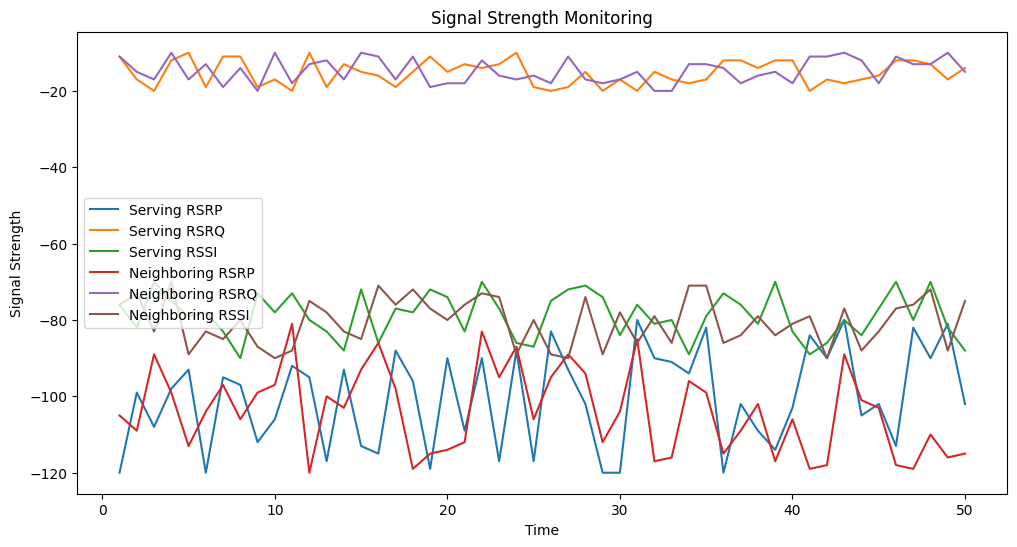

Serving RSRP Mean: -100.38
Serving RSRP Median: -98.5
Serving RSRQ Standard Deviation: 3.2078029864690882


In [ ]:
import random
import time
import csv
import matplotlib.pyplot as plt
import numpy as np

# Define handover threshold
HANDOVER_THRESHOLD = 70

# Define event threshold
EVENT_THRESHOLD = 90

# Define hysteresis values
HANDOVER_HYSTERESIS = 5
EVENT_HYSTERESIS = 3

# Define signal quality trend thresholds
SIGNAL_QUALITY_TREND_THRESHOLD = 3

# Define function to generate random signal strengths (RSRP, RSRQ, RSSI) for serving and neighboring eNBs
def generate_signal_strength():
    serving_rsrp = random.randint(-120, -80)
    serving_rsrq = random.randint(-20, -10)
    serving_rssi = random.randint(-90, -70)
    neighboring_rsrp = random.randint(-120, -80)
    neighboring_rsrq = random.randint(-20, -10)
    neighboring_rssi = random.randint(-90, -70)
    return serving_rsrp, serving_rsrq, serving_rssi, neighboring_rsrp, neighboring_rsrq, neighboring_rssi

# Define function to check if handover is needed
def is_handover_needed(serving_rsrp, serving_rsrq, serving_rsrp_trend):
    if serving_rsrp < HANDOVER_THRESHOLD - HANDOVER_HYSTERESIS and serving_rsrp_trend < -SIGNAL_QUALITY_TREND_THRESHOLD:
        return True
    return False

# Define function to check if event is triggered
def is_event_triggered(serving_rsrq, neighboring_cell_load, congestion):
    if serving_rsrq > EVENT_THRESHOLD + EVENT_HYSTERESIS and neighboring_cell_load < congestion:
        return True
    return False

# Define function to calculate signal quality trend
def calculate_signal_quality_trend(values):
    if len(values) < 2:
        return 0
    return values[-1] - values[-2]

# Define function to perform handover
def perform_handover():
    print("Handover initiated...")

# Define main function
def main():
    # Generate initial signal strengths (RSRP, RSRQ, RSSI) for serving and neighboring eNBs
    serving_rsrp, serving_rsrq, serving_rssi, neighboring_rsrp, neighboring_rsrq, neighboring_rssi = generate_signal_strength()

    # Define empty lists for data collection
    serving_rsrp_data = []
    serving_rsrq_data = []
    serving_rssi_data = []
    neighboring_rsrp_data = []
    neighboring_rsrq_data = []
    neighboring_rssi_data = []

    # Define empty list for serving RSRP trend
    serving_rsrp_trend_data = []

    # Define loop counter
    iterations = 0

    # Create a CSV file for logging data
    with open('signal_data.csv', mode='w', newline='') as file:
        writer = csv.writer(file)
        writer.writerow(['Iteration', 'Serving RSRP', 'Serving RSRQ', 'Serving RSSI', 'Neighboring RSRP', 'Neighboring RSRQ', 'Neighboring RSSI'])

        # Loop while counter is less than 50
        while iterations < 50:
            # Generate new signal strengths (RSRP, RSRQ, RSSI) for serving and neighboring eNBs
            new_serving_rsrp, new_serving_rsrq, new_serving_rssi, new_neighboring_rsrp, new_neighboring_rsrq, new_neighboring_rssi = generate_signal_strength()

            # Calculate the serving RSRP trend
            serving_rsrp_trend = calculate_signal_quality_trend(serving_rsrp_data)

            # Check if handover is needed
            if is_handover_needed(new_serving_rsrp, new_serving_rsrq, serving_rsrp_trend):
                perform_handover()
                serving_rsrp, serving_rsrq, serving_rssi = new_serving_rsrp, new_serving_rsrq, new_serving_rssi
                neighboring_rsrp, neighboring_rsrq, neighboring_rssi = new_neighboring_rsrp, new_neighboring_rsrq, new_neighboring_rssi
            # Check if event is triggered
            elif is_event_triggered(new_serving_rsrq, neighboring_rsrq, serving_rsrq):
                print("Event triggered!")
                serving_rsrp, serving_rsrq, serving_rssi = new_serving_rsrp, new_serving_rsrq, new_serving_rssi
                neighboring_rsrp, neighboring_rsrq, neighboring_rssi = new_neighboring_rsrp, new_neighboring_rsrq, new_neighboring_rssi
            else:
                serving_rsrp, serving_rsrq, serving_rssi = new_serving_rsrp, new_serving_rsrq, new_serving_rssi
                neighboring_rsrp, neighboring_rsrq, neighboring_rssi = new_neighboring_rsrp, new_neighboring_rsrq, new_neighboring_rssi

            # Append the signal strength values to the data lists
            serving_rsrp_data.append(serving_rsrp)
            serving_rsrq_data.append(serving_rsrq)
            serving_rssi_data.append(serving_rssi)
            neighboring_rsrp_data.append(neighboring_rsrp)
            neighboring_rsrq_data.append(neighboring_rsrq)
            neighboring_rssi_data.append(neighboring_rssi)

            # Append data to the CSV file
            writer.writerow([iterations+1, serving_rsrp, serving_rsrq, serving_rssi, neighboring_rsrp, neighboring_rsrq, neighboring_rssi])

            # Increment loop counter
            iterations += 1

            # Sleep for 1 second
            time.sleep(1)

    # Plotting the data
    time_steps = range(1, iterations+1)

    plt.figure(figsize=(12, 6))
    plt.plot(time_steps, serving_rsrp_data, label='Serving RSRP')
    plt.plot(time_steps, serving_rsrq_data, label='Serving RSRQ')
    plt.plot(time_steps, serving_rssi_data, label='Serving RSSI')
    plt.plot(time_steps, neighboring_rsrp_data, label='Neighboring RSRP')
    plt.plot(time_steps, neighboring_rsrq_data, label='Neighboring RSRQ')
    plt.plot(time_steps, neighboring_rssi_data, label='Neighboring RSSI')
    plt.xlabel('Time')
    plt.ylabel('Signal Strength')
    plt.title('Signal Strength Monitoring')
    plt.legend()
    plt.show()

    # Statistical analysis
    print("Serving RSRP Mean:", np.mean(serving_rsrp_data))
    print("Serving RSRP Median:", np.median(serving_rsrp_data))
    print("Serving RSRQ Standard Deviation:", np.std(serving_rsrq_data))
    # Perform similar calculations for other signal strength parameters

# Call main function
if __name__ == '__main__':
    main()


Handover initiated...
Handover initiated...
Handover initiated...
Handover initiated...
Handover initiated...
Handover initiated...
Handover initiated...
Handover initiated...
Handover initiated...
Handover initiated...
Handover initiated...
Handover initiated...
Handover initiated...
Handover initiated...
Handover initiated...
Handover initiated...
Handover initiated...
Handover initiated...


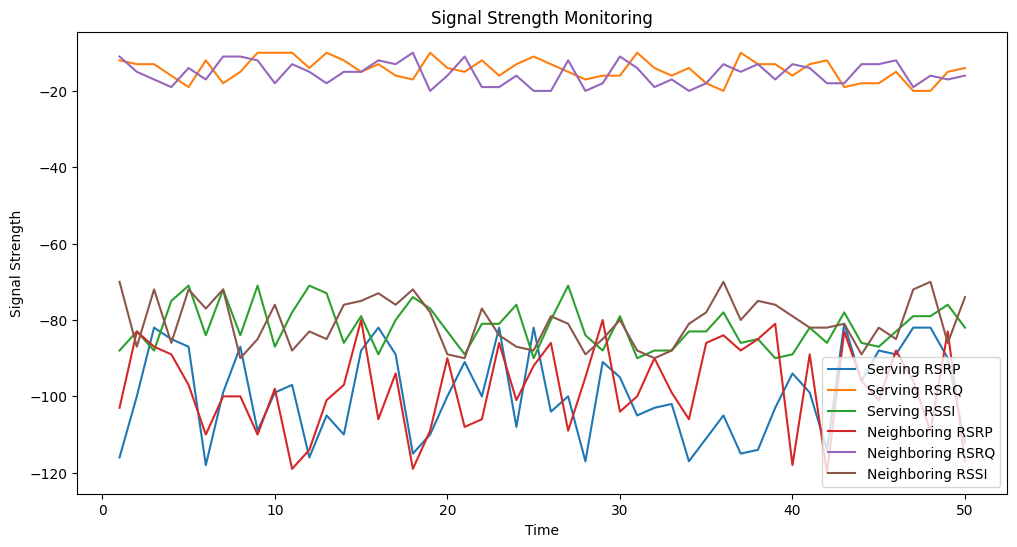

Serving RSRP Mean: -99.32
Serving RSRP Median: -100.0
Serving RSRQ Standard Deviation: 2.8781243892507495


In [ ]:
import random
import time
import csv
import matplotlib.pyplot as plt
import numpy as np

# Define handover threshold
HANDOVER_THRESHOLD = 70

# Define event threshold
EVENT_THRESHOLD = 90

# Define hysteresis values
HANDOVER_HYSTERESIS = 5
EVENT_HYSTERESIS = 3

# Define signal quality trend thresholds
SIGNAL_QUALITY_TREND_THRESHOLD = 3

# Define function to generate random signal strengths (RSRP, RSRQ, RSSI) for serving and neighboring eNBs
def generate_signal_strength():
    serving_rsrp = random.randint(-120, -80)
    serving_rsrq = random.randint(-20, -10)
    serving_rssi = random.randint(-90, -70)
    neighboring_rsrp = random.randint(-120, -80)
    neighboring_rsrq = random.randint(-20, -10)
    neighboring_rssi = random.randint(-90, -70)
    return serving_rsrp, serving_rsrq, serving_rssi, neighboring_rsrp, neighboring_rsrq, neighboring_rssi

# Define function to check if handover is needed
def is_handover_needed(serving_rsrp, serving_rsrq, serving_rsrp_trend):
    if serving_rsrp < HANDOVER_THRESHOLD - HANDOVER_HYSTERESIS and serving_rsrp_trend < -SIGNAL_QUALITY_TREND_THRESHOLD:
        return True
    return False

# Define function to check if event is triggered
def is_event_triggered(serving_rsrq, neighboring_cell_load, congestion):
    if serving_rsrq > EVENT_THRESHOLD + EVENT_HYSTERESIS and neighboring_cell_load < congestion:
        return True
    return False

# Define function to calculate signal quality trend
def calculate_signal_quality_trend(values):
    if len(values) < 2:
        return 0
    return values[-1] - values[-2]

# Define function to perform handover
def perform_handover():
    print("Handover initiated...")

# Define main function
def main():
    try:
        # Generate initial signal strengths (RSRP, RSRQ, RSSI) for serving and neighboring eNBs
        serving_rsrp, serving_rsrq, serving_rssi, neighboring_rsrp, neighboring_rsrq, neighboring_rssi = generate_signal_strength()

        # Define empty lists for data collection
        serving_rsrp_data = []
        serving_rsrq_data = []
        serving_rssi_data = []
        neighboring_rsrp_data = []
        neighboring_rsrq_data = []
        neighboring_rssi_data = []

        # Define empty list for serving RSRP trend
        serving_rsrp_trend_data = []

        # Define loop counter
        iterations = 0

        # Create a CSV file for logging data
        with open('signal_data.csv', mode='w', newline='') as file:
            writer = csv.writer(file)
            writer.writerow(['Iteration', 'Serving RSRP', 'Serving RSRQ', 'Serving RSSI', 'Neighboring RSRP', 'Neighboring RSRQ', 'Neighboring RSSI'])

            # Loop while counter is less than 50
            while iterations < 50:
                # Generate new signal strengths (RSRP, RSRQ, RSSI) for serving and neighboring eNBs
                new_serving_rsrp, new_serving_rsrq, new_serving_rssi, new_neighboring_rsrp, new_neighboring_rsrq, new_neighboring_rssi = generate_signal_strength()

                # Calculate the serving RSRP trend
                serving_rsrp_trend = calculate_signal_quality_trend(serving_rsrp_data)

                # Check if handover is needed
                if is_handover_needed(new_serving_rsrp, new_serving_rsrq, serving_rsrp_trend):
                    perform_handover()
                    serving_rsrp, serving_rsrq, serving_rssi = new_serving_rsrp, new_serving_rsrq, new_serving_rssi
                    neighboring_rsrp, neighboring_rsrq, neighboring_rssi = new_neighboring_rsrp, new_neighboring_rsrq, new_neighboring_rssi
                # Check if event is triggered
                elif is_event_triggered(new_serving_rsrq, neighboring_rsrq, serving_rsrq):
                    print("Event triggered!")
                    serving_rsrp, serving_rsrq, serving_rssi = new_serving_rsrp, new_serving_rsrq, new_serving_rssi
                    neighboring_rsrp, neighboring_rsrq, neighboring_rssi = new_neighboring_rsrp, new_neighboring_rsrq, new_neighboring_rssi
                else:
                    serving_rsrp, serving_rsrq, serving_rssi = new_serving_rsrp, new_serving_rsrq, new_serving_rssi
                    neighboring_rsrp, neighboring_rsrq, neighboring_rssi = new_neighboring_rsrp, new_neighboring_rsrq, new_neighboring_rssi

                # Append the signal strength values to the data lists
                serving_rsrp_data.append(serving_rsrp)
                serving_rsrq_data.append(serving_rsrq)
                serving_rssi_data.append(serving_rssi)
                neighboring_rsrp_data.append(neighboring_rsrp)
                neighboring_rsrq_data.append(neighboring_rsrq)
                neighboring_rssi_data.append(neighboring_rssi)

                # Append data to the CSV file
                writer.writerow([iterations+1, serving_rsrp, serving_rsrq, serving_rssi, neighboring_rsrp, neighboring_rsrq, neighboring_rssi])

                # Increment loop counter
                iterations += 1

                # Sleep for 1 second
                time.sleep(1)

        # Plotting the data
        time_steps = range(1, iterations+1)

        plt.figure(figsize=(12, 6))
        plt.plot(time_steps, serving_rsrp_data, label='Serving RSRP')
        plt.plot(time_steps, serving_rsrq_data, label='Serving RSRQ')
        plt.plot(time_steps, serving_rssi_data, label='Serving RSSI')
        plt.plot(time_steps, neighboring_rsrp_data, label='Neighboring RSRP')
        plt.plot(time_steps, neighboring_rsrq_data, label='Neighboring RSRQ')
        plt.plot(time_steps, neighboring_rssi_data, label='Neighboring RSSI')
        plt.xlabel('Time')
        plt.ylabel('Signal Strength')
        plt.title('Signal Strength Monitoring')
        plt.legend()
        plt.show()

        # Statistical analysis
        print("Serving RSRP Mean:", np.mean(serving_rsrp_data))
        print("Serving RSRP Median:", np.median(serving_rsrp_data))
        print("Serving RSRQ Standard Deviation:", np.std(serving_rsrq_data))
        # Perform similar calculations for other signal strength parameters

    except Exception as e:
        print("An error occurred:", str(e))

# Call main function
if __name__ == '__main__':
    main()


Handover initiated...
Handover initiated...
Handover initiated...
Handover initiated...
Handover initiated...
Handover initiated...
Handover initiated...
Handover initiated...
Handover initiated...
Handover initiated...
Handover initiated...
Handover initiated...
Handover initiated...
Handover initiated...
Handover initiated...
Handover initiated...


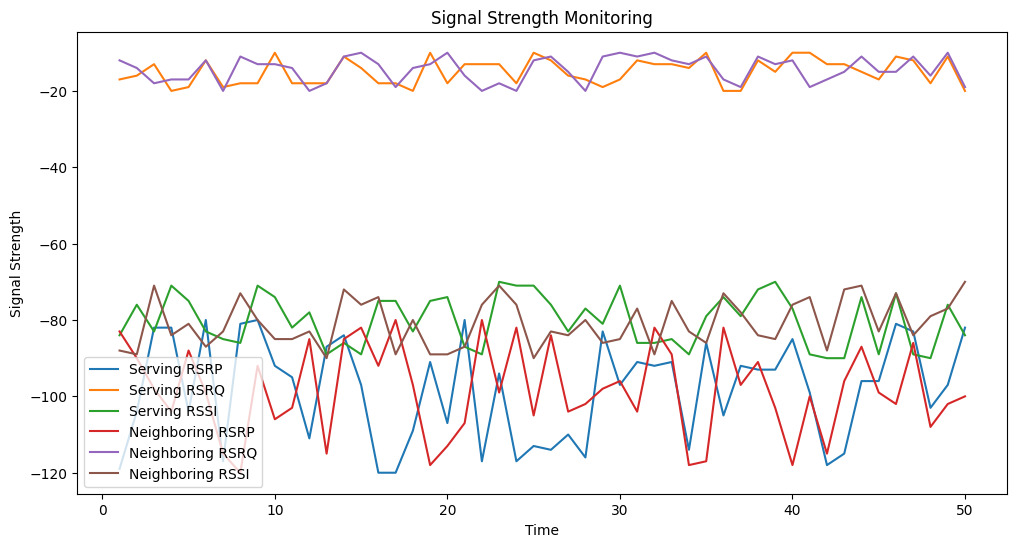

Serving RSRP Mean: -98.3
Serving RSRP Median: -96.0
Serving RSRQ Standard Deviation: 3.340419135378074


In [ ]:
import random
import time
import csv
import matplotlib.pyplot as plt
import numpy as np
import logging

# Configure logging
logging.basicConfig(filename='signal_strength.log', level=logging.INFO, format='%(asctime)s %(levelname)s: %(message)s')

# Define handover threshold
HANDOVER_THRESHOLD = 70

# Define event threshold
EVENT_THRESHOLD = 90

# Define hysteresis values
HANDOVER_HYSTERESIS = 5
EVENT_HYSTERESIS = 3

# Define signal quality trend thresholds
SIGNAL_QUALITY_TREND_THRESHOLD = 3

# Define function to generate random signal strengths (RSRP, RSRQ, RSSI) for serving and neighboring eNBs
def generate_signal_strength():
    serving_rsrp = random.randint(-120, -80)
    serving_rsrq = random.randint(-20, -10)
    serving_rssi = random.randint(-90, -70)
    neighboring_rsrp = random.randint(-120, -80)
    neighboring_rsrq = random.randint(-20, -10)
    neighboring_rssi = random.randint(-90, -70)
    return serving_rsrp, serving_rsrq, serving_rssi, neighboring_rsrp, neighboring_rsrq, neighboring_rssi

# Define function to check if handover is needed
def is_handover_needed(serving_rsrp, serving_rsrq, serving_rsrp_trend):
    if serving_rsrp < HANDOVER_THRESHOLD - HANDOVER_HYSTERESIS and serving_rsrp_trend < -SIGNAL_QUALITY_TREND_THRESHOLD:
        return True
    return False

# Define function to check if event is triggered
def is_event_triggered(serving_rsrq, neighboring_cell_load, congestion):
    if serving_rsrq > EVENT_THRESHOLD + EVENT_HYSTERESIS and neighboring_cell_load < congestion:
        return True
    return False

# Define function to calculate signal quality trend
def calculate_signal_quality_trend(values):
    if len(values) < 2:
        return 0
    return values[-1] - values[-2]

# Define function to perform handover
def perform_handover():
    print("Handover initiated...")
    logging.info("Handover initiated")

# Define main function
def main():
    try:
        # Generate initial signal strengths (RSRP, RSRQ, RSSI) for serving and neighboring eNBs
        serving_rsrp, serving_rsrq, serving_rssi, neighboring_rsrp, neighboring_rsrq, neighboring_rssi = generate_signal_strength()

        # Define empty lists for data collection
        serving_rsrp_data = []
        serving_rsrq_data = []
        serving_rssi_data = []
        neighboring_rsrp_data = []
        neighboring_rsrq_data = []
        neighboring_rssi_data = []

        # Define empty list for serving RSRP trend
        serving_rsrp_trend_data = []

        # Define loop counter
        iterations = 0

        # Create a CSV file for logging data
        with open('signal_data.csv', mode='w', newline='') as file:
            writer = csv.writer(file)
            writer.writerow(['Iteration', 'Serving RSRP', 'Serving RSRQ', 'Serving RSSI', 'Neighboring RSRP', 'Neighboring RSRQ', 'Neighboring RSSI'])

            # Loop while counter is less than 50
            while iterations < 50:
                # Generate new signal strengths (RSRP, RSRQ, RSSI) for serving and neighboring eNBs
                new_serving_rsrp, new_serving_rsrq, new_serving_rssi, new_neighboring_rsrp, new_neighboring_rsrq, new_neighboring_rssi = generate_signal_strength()

                # Calculate the serving RSRP trend
                serving_rsrp_trend = calculate_signal_quality_trend(serving_rsrp_data)

                # Check if handover is needed
                if is_handover_needed(new_serving_rsrp, new_serving_rsrq, serving_rsrp_trend):
                    perform_handover()
                    serving_rsrp, serving_rsrq, serving_rssi = new_serving_rsrp, new_serving_rsrq, new_serving_rssi
                    neighboring_rsrp, neighboring_rsrq, neighboring_rssi = new_neighboring_rsrp, new_neighboring_rsrq, new_neighboring_rssi
                # Check if event is triggered
                elif is_event_triggered(new_serving_rsrq, neighboring_rsrq, serving_rsrq):
                    print("Event triggered!")
                    logging.info("Event triggered")
                    serving_rsrp, serving_rsrq, serving_rssi = new_serving_rsrp, new_serving_rsrq, new_serving_rssi
                    neighboring_rsrp, neighboring_rsrq, neighboring_rssi = new_neighboring_rsrp, new_neighboring_rsrq, new_neighboring_rssi
                else:
                    serving_rsrp, serving_rsrq, serving_rssi = new_serving_rsrp, new_serving_rsrq, new_serving_rssi
                    neighboring_rsrp, neighboring_rsrq, neighboring_rssi = new_neighboring_rsrp, new_neighboring_rsrq, new_neighboring_rssi

                # Append the signal strength values to the data lists
                serving_rsrp_data.append(serving_rsrp)
                serving_rsrq_data.append(serving_rsrq)
                serving_rssi_data.append(serving_rssi)
                neighboring_rsrp_data.append(neighboring_rsrp)
                neighboring_rsrq_data.append(neighboring_rsrq)
                neighboring_rssi_data.append(neighboring_rssi)

                # Append data to the CSV file
                writer.writerow([iterations+1, serving_rsrp, serving_rsrq, serving_rssi, neighboring_rsrp, neighboring_rsrq, neighboring_rssi])

                # Increment loop counter
                iterations += 1

                # Sleep for 1 second
                time.sleep(1)

        # Plotting the data
        time_steps = range(1, iterations+1)

        plt.figure(figsize=(12, 6))
        plt.plot(time_steps, serving_rsrp_data, label='Serving RSRP')
        plt.plot(time_steps, serving_rsrq_data, label='Serving RSRQ')
        plt.plot(time_steps, serving_rssi_data, label='Serving RSSI')
        plt.plot(time_steps, neighboring_rsrp_data, label='Neighboring RSRP')
        plt.plot(time_steps, neighboring_rsrq_data, label='Neighboring RSRQ')
        plt.plot(time_steps, neighboring_rssi_data, label='Neighboring RSSI')
        plt.xlabel('Time')
        plt.ylabel('Signal Strength')
        plt.title('Signal Strength Monitoring')
        plt.legend()
        plt.show()

        # Statistical analysis
        print("Serving RSRP Mean:", np.mean(serving_rsrp_data))
        print("Serving RSRP Median:", np.median(serving_rsrp_data))
        print("Serving RSRQ Standard Deviation:", np.std(serving_rsrq_data))
        # Perform similar calculations for other signal strength parameters

    except Exception as e:
        print("An error occurred:", str(e))
        logging.error("An error occurred: %s", str(e))

# Call main function
if __name__ == '__main__':
    main()


In [ ]:
import random
import time
import csv
import matplotlib.pyplot as plt
import numpy as np
import logging

# Configure logging
logging.basicConfig(filename='signal_strength.log', level=logging.INFO, format='%(asctime)s %(levelname)s: %(message)s')

# Define handover threshold
HANDOVER_THRESHOLD = 70

# Define event threshold
EVENT_THRESHOLD = 90

# Define hysteresis values
HANDOVER_HYSTERESIS = 5
EVENT_HYSTERESIS = 3

# Define signal quality trend thresholds
SIGNAL_QUALITY_TREND_THRESHOLD = 3

# Define function to generate random signal strengths (RSRP, RSRQ, RSSI) for serving and neighboring eNBs based on user location
def generate_signal_strength(user_location):
    serving_rsrp = random.randint(-120, -80)
    serving_rsrq = random.randint(-20, -10)
    serving_rssi = random.randint(-90, -70)
    neighboring_rsrp = random.randint(-120, -80)
    neighboring_rsrq = random.randint(-20, -10)
    neighboring_rssi = random.randint(-90, -70)
    return serving_rsrp, serving_rsrq, serving_rssi, neighboring_rsrp, neighboring_rsrq, neighboring_rssi

# Define function to check if handover is needed
def is_handover_needed(serving_rsrp, serving_rsrq, serving_rsrp_trend):
    if serving_rsrp < HANDOVER_THRESHOLD - HANDOVER_HYSTERESIS and serving_rsrp_trend < -SIGNAL_QUALITY_TREND_THRESHOLD:
        return True
    return False

# Define function to check if event is triggered
def is_event_triggered(serving_rsrq, neighboring_cell_load, congestion):
    if serving_rsrq > EVENT_THRESHOLD + EVENT_HYSTERESIS and neighboring_cell_load < congestion:
        return True
    return False

# Define function to calculate signal quality trend
def calculate_signal_quality_trend(values):
    if len(values) < 2:
        return 0
    return values[-1] - values[-2]

# Define function to perform handover
def perform_handover():
    print("Handover initiated...")
    logging.info("Handover initiated")

# Define main function
def main():
    try:
        # Generate initial signal strengths (RSRP, RSRQ, RSSI) for serving and neighboring eNBs
        user_location = (0, 0)  # Initial user location in 2D (x, y) coordinates
        serving_rsrp, serving_rsrq, serving_rssi, neighboring_rsrp, neighboring_rsrq, neighboring_rssi = generate_signal_strength(user_location)

        # Define empty lists for data collection
        serving_rsrp_data = []
        serving_rsrq_data = []
        serving_rssi_data = []
        neighboring_rsrp_data = []
        neighboring_rsrq_data = []
        neighboring_rssi_data = []

        # Define empty list for serving RSRP trend
        serving_rsrp_trend_data = []

        # Define loop counter
        iterations = 0

        # Create a CSV file for logging data
        with open('signal_data.csv', mode='w', newline='') as file:
            writer = csv.writer(file)
            writer.writerow(['Iteration', 'Serving RSRP', 'Serving RSRQ', 'Serving RSSI', 'Neighboring RSRP', 'Neighboring RSRQ', 'Neighboring RSSI'])

            # Loop while counter is less than 50
            while iterations < 50:
                # Generate new signal strengths (RSRP, RSRQ, RSSI) for serving and neighboring eNBs based on user location
                new_serving_rsrp, new_serving_rsrq, new_serving_rssi, new_neighboring_rsrp, new_neighboring_rsrq, new_neighboring_rssi = generate_signal_strength(user_location)

                # Calculate the serving RSRP trend
                serving_rsrp_trend = calculate_signal_quality_trend(serving_rsrp_data)

                # Check if handover is needed
                if is_handover_needed(new_serving_rsrp, new_serving_rsrq, serving_rsrp_trend):
                    perform_handover()
                    serving_rsrp, serving_rsrq, serving_rssi = new_serving_rsrp, new_serving_rsrq, new_serving_rssi
                    neighboring_rsrp, neighboring_rsrq, neighboring_rssi = new_neighboring_rsrp, new_neighboring_rsrq, new_neighboring_rssi
                # Check if event is triggered
                elif is_event_triggered(new_serving_rsrq, neighboring_rsrq, serving_rsrq):
                    print("Event triggered!")
                    logging.info("Event triggered")
                    serving_rsrp, serving_rsrq, serving_rssi = new_serving_rsrp, new_serving_rsrq, new_serving_rssi
                    neighboring_rsrp, neighboring_rsrq, neighboring_rssi = new_neighboring_rsrp, new_neighboring_rsrq, new_neighboring_rssi
                else:
                    serving_rsrp, serving_rsrq, serving_rssi = new_serving_rsrp, new_serving_rsrq, new_serving_rssi
                    neighboring_rsrp, neighboring_rsrq, neighboring_rssi = new_neighboring_rsrp, new_neighboring_rsrq, new_neighboring_rssi

                # Append the signal strength values to the data lists
                serving_rsrp_data.append(serving_rsrp)
                serving_rsrq_data.append(serving_rsrq)
                serving_rssi_data.append(serving_rssi)
                neighboring_rsrp_data.append(neighboring_rsrp)
                neighboring_rsrq_data.append(neighboring_rsrq)
                neighboring_rssi_data.append(neighboring_rssi)

                # Append data to the CSV file
                writer.writerow([iterations+1, serving_rsrp, serving_rsrq, serving_rssi, neighboring_rsrp, neighboring_rsrq, neighboring_rssi])

                # Update user location and velocity based on real data or movement simulation
                user_location = update_user_location(user_location)

                # Increment loop counter
                iterations += 1

                # Sleep for 1 second
                time.sleep(1)

        # Plotting the data
        time_steps = range(1, iterations+1)

        plt.figure(figsize=(12, 6))
        plt.plot(time_steps, serving_rsrp_data, label='Serving RSRP')
        plt.plot(time_steps, serving_rsrq_data, label='Serving RSRQ')
        plt.plot(time_steps, serving_rssi_data, label='Serving RSSI')
        plt.plot(time_steps, neighboring_rsrp_data, label='Neighboring RSRP')
        plt.plot(time_steps, neighboring_rsrq_data, label='Neighboring RSRQ')
        plt.plot(time_steps, neighboring_rssi_data, label='Neighboring RSSI')
        plt.xlabel('Time')
        plt.ylabel('Signal Strength')
        plt.title('Signal Strength Monitoring')
        plt.legend()
        plt.show()

        # Statistical analysis
        print("Serving RSRP Mean:", np.mean(serving_rsrp_data))
        print("Serving RSRP Median:", np.median(serving_rsrp_data))
        print("Serving RSRQ Standard Deviation:", np.std(serving_rsrq_data))
        # Perform similar calculations for other signal strength parameters

    except Exception as e:
        print("An error occurred:", str(e))
        logging.error("An error occurred: %s", str(e))

# Function to update user location based on movement simulation or real data
def update_user_location(current_location):
    # Simulating random movement in the x and y coordinates
    x_movement = random.uniform(-1, 1)
    y_movement = random.uniform(-1, 1)
    new_location = (current_location[0] + x_movement, current_location[1] + y_movement)
    return new_location

# Call main function
if __name__ == '__main__':
    main()


KeyboardInterrupt: ignored

Handover initiated...
Handover initiated...
Handover initiated...
Handover initiated...
Handover initiated...
Handover initiated...
Handover initiated...
Handover initiated...
Handover initiated...
Handover initiated...
Handover initiated...
Handover initiated...
Handover initiated...
Handover initiated...
Handover initiated...
Handover initiated...
Handover initiated...
Handover initiated...
Handover initiated...
Handover initiated...
Handover initiated...


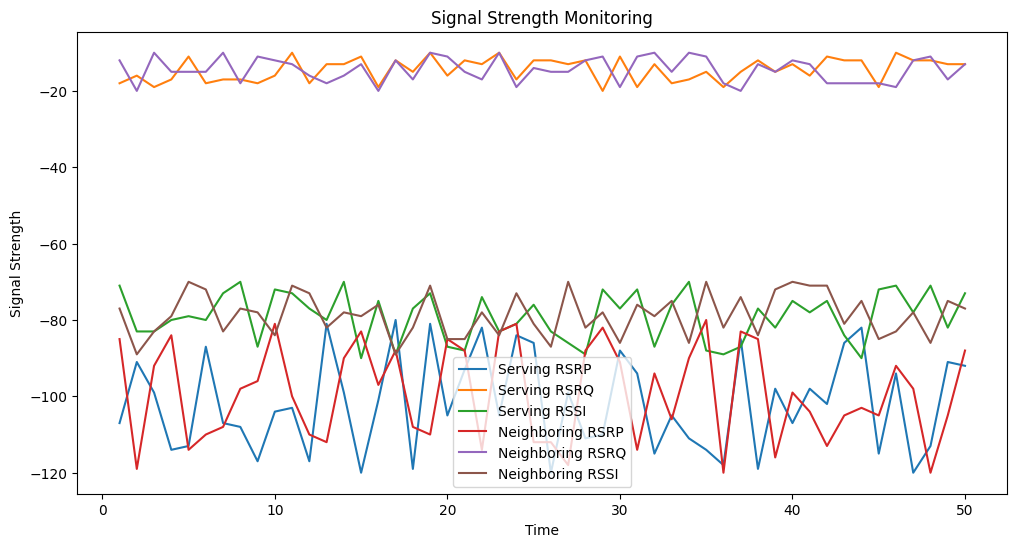

Serving RSRP Mean: -101.8
Serving RSRP Median: -103.5
Serving RSRQ Standard Deviation: 2.981006541421874


In [ ]:
import random
import time
import csv
import matplotlib.pyplot as plt
import numpy as np
import logging

# Configure logging
logging.basicConfig(filename='signal_strength.log', level=logging.INFO, format='%(asctime)s %(levelname)s: %(message)s')

# Define handover threshold
HANDOVER_THRESHOLD = 70

# Define event threshold
EVENT_THRESHOLD = 90

# Define hysteresis values
HANDOVER_HYSTERESIS = 5
EVENT_HYSTERESIS = 3

# Define signal quality trend thresholds
SIGNAL_QUALITY_TREND_THRESHOLD = 3

# Define LTE parameters
lte_params = {
    'frequency': 1800,  # in MHz
    'bs_tx_power': 46,  # in dBm
    'noise_figure': 9,  # in dB
    'bandwidth': 10e6,  # in Hz
}

# Define function to generate random signal strengths (RSRP, RSRQ, RSSI) for serving and neighboring eNBs based on user location and LTE parameters
def generate_signal_strength(user_location):
    serving_rsrp = calculate_rsrp(user_location, lte_params)
    serving_rsrq = calculate_rsrq(user_location, lte_params)
    serving_rssi = calculate_rssi(user_location, lte_params)
    neighboring_rsrp = calculate_rsrp(user_location, lte_params)
    neighboring_rsrq = calculate_rsrq(user_location, lte_params)
    neighboring_rssi = calculate_rssi(user_location, lte_params)
    return serving_rsrp, serving_rsrq, serving_rssi, neighboring_rsrp, neighboring_rsrq, neighboring_rssi

# Define function to calculate RSRP based on user location and LTE parameters
def calculate_rsrp(user_location, lte_params):
    # Implement the RSRP calculation based on user location and LTE parameters
    # Example calculation using random value for demonstration
    rsrp = random.randint(-120, -80)
    return rsrp

# Define function to calculate RSRQ based on user location and LTE parameters
def calculate_rsrq(user_location, lte_params):
    # Implement the RSRQ calculation based on user location and LTE parameters
    # Example calculation using random value for demonstration
    rsrq = random.randint(-20, -10)
    return rsrq

# Define function to calculate RSSI based on user location and LTE parameters
def calculate_rssi(user_location, lte_params):
    # Implement the RSSI calculation based on user location and LTE parameters
    # Example calculation using random value for demonstration
    rssi = random.randint(-90, -70)
    return rssi

# Define function to check if handover is needed
def is_handover_needed(serving_rsrp, serving_rsrq, serving_rsrp_trend):
    if serving_rsrp < HANDOVER_THRESHOLD - HANDOVER_HYSTERESIS and serving_rsrp_trend < -SIGNAL_QUALITY_TREND_THRESHOLD:
        return True
    return False

# Define function to check if event is triggered
def is_event_triggered(serving_rsrq, neighboring_cell_load, congestion):
    if serving_rsrq > EVENT_THRESHOLD + EVENT_HYSTERESIS and neighboring_cell_load < congestion:
        return True
    return False

# Define function to calculate signal quality trend
def calculate_signal_quality_trend(values):
    if len(values) < 2:
        return 0
    return values[-1] - values[-2]

# Define function to perform handover
def perform_handover():
    print("Handover initiated...")
    logging.info("Handover initiated")

# Define main function
def main():
    try:
        # Generate initial signal strengths (RSRP, RSRQ, RSSI) for serving and neighboring eNBs
        user_location = (0, 0)  # Initial user location in 2D (x, y) coordinates
        serving_rsrp, serving_rsrq, serving_rssi, neighboring_rsrp, neighboring_rsrq, neighboring_rssi = generate_signal_strength(user_location)

        # Define empty lists for data collection
        serving_rsrp_data = []
        serving_rsrq_data = []
        serving_rssi_data = []
        neighboring_rsrp_data = []
        neighboring_rsrq_data = []
        neighboring_rssi_data = []

        # Define empty list for serving RSRP trend
        serving_rsrp_trend_data = []

        # Define loop counter
        iterations = 0

        # Create a CSV file for logging data
        with open('signal_data.csv', mode='w', newline='') as file:
            writer = csv.writer(file)
            writer.writerow(['Iteration', 'Serving RSRP', 'Serving RSRQ', 'Serving RSSI', 'Neighboring RSRP', 'Neighboring RSRQ', 'Neighboring RSSI'])

            # Loop while counter is less than 50
            while iterations < 50:
                # Generate new signal strengths (RSRP, RSRQ, RSSI) for serving and neighboring eNBs based on user location
                new_serving_rsrp, new_serving_rsrq, new_serving_rssi, new_neighboring_rsrp, new_neighboring_rsrq, new_neighboring_rssi = generate_signal_strength(user_location)

                # Calculate the serving RSRP trend
                serving_rsrp_trend = calculate_signal_quality_trend(serving_rsrp_data)

                # Check if handover is needed
                if is_handover_needed(new_serving_rsrp, new_serving_rsrq, serving_rsrp_trend):
                    perform_handover()
                    serving_rsrp, serving_rsrq, serving_rssi = new_serving_rsrp, new_serving_rsrq, new_serving_rssi
                    neighboring_rsrp, neighboring_rsrq, neighboring_rssi = new_neighboring_rsrp, new_neighboring_rsrq, new_neighboring_rssi
                # Check if event is triggered
                elif is_event_triggered(new_serving_rsrq, neighboring_rsrq, serving_rsrq):
                    print("Event triggered!")
                    logging.info("Event triggered")
                    serving_rsrp, serving_rsrq, serving_rssi = new_serving_rsrp, new_serving_rsrq, new_serving_rssi
                    neighboring_rsrp, neighboring_rsrq, neighboring_rssi = new_neighboring_rsrp, new_neighboring_rsrq, new_neighboring_rssi
                else:
                    serving_rsrp, serving_rsrq, serving_rssi = new_serving_rsrp, new_serving_rsrq, new_serving_rssi
                    neighboring_rsrp, neighboring_rsrq, neighboring_rssi = new_neighboring_rsrp, new_neighboring_rsrq, new_neighboring_rssi

                # Append the signal strength values to the data lists
                serving_rsrp_data.append(serving_rsrp)
                serving_rsrq_data.append(serving_rsrq)
                serving_rssi_data.append(serving_rssi)
                neighboring_rsrp_data.append(neighboring_rsrp)
                neighboring_rsrq_data.append(neighboring_rsrq)
                neighboring_rssi_data.append(neighboring_rssi)

                # Append data to the CSV file
                writer.writerow([iterations+1, serving_rsrp, serving_rsrq, serving_rssi, neighboring_rsrp, neighboring_rsrq, neighboring_rssi])

                # Update user location and velocity based on real data or movement simulation
                user_location = update_user_location(user_location)

                # Increment loop counter
                iterations += 1

                # Sleep for 1 second
                time.sleep(1)

        # Plotting the data
        time_steps = range(1, iterations+1)

        plt.figure(figsize=(12, 6))
        plt.plot(time_steps, serving_rsrp_data, label='Serving RSRP')
        plt.plot(time_steps, serving_rsrq_data, label='Serving RSRQ')
        plt.plot(time_steps, serving_rssi_data, label='Serving RSSI')
        plt.plot(time_steps, neighboring_rsrp_data, label='Neighboring RSRP')
        plt.plot(time_steps, neighboring_rsrq_data, label='Neighboring RSRQ')
        plt.plot(time_steps, neighboring_rssi_data, label='Neighboring RSSI')
        plt.xlabel('Time')
        plt.ylabel('Signal Strength')
        plt.title('Signal Strength Monitoring')
        plt.legend()
        plt.show()

        # Statistical analysis
        print("Serving RSRP Mean:", np.mean(serving_rsrp_data))
        print("Serving RSRP Median:", np.median(serving_rsrp_data))
        print("Serving RSRQ Standard Deviation:", np.std(serving_rsrq_data))
        # Perform similar calculations for other signal strength parameters

    except Exception as e:
        print("An error occurred:", str(e))
        logging.error("An error occurred: %s", str(e))

# Function to update user location based on movement simulation or real data
def update_user_location(current_location):
    # Simulating random movement in the x and y coordinates
    x_movement = random.uniform(-1, 1)
    y_movement = random.uniform(-1, 1)
    new_location = (current_location[0] + x_movement, current_location[1] + y_movement)
    return new_location

# Call main function
if __name__ == '__main__':
    main()


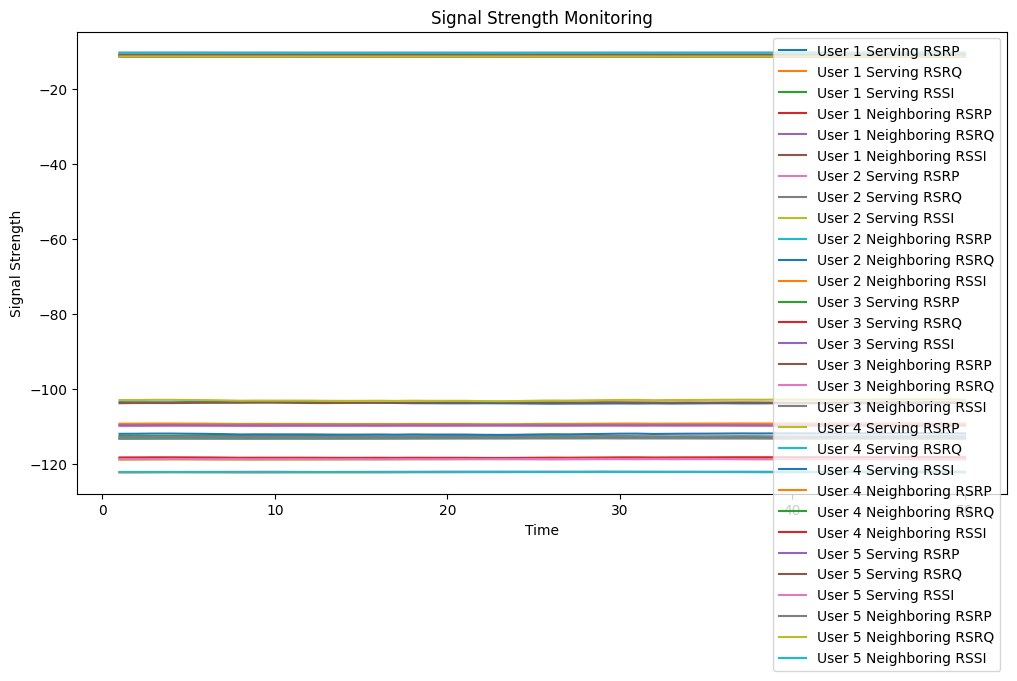

User 1 Serving RSRP Mean: -103.74538165214824
User 1 Serving RSRP Median: -103.80693514729583
User 1 Serving RSRQ Standard Deviation: 0.014454352895460045
User 2 Serving RSRP Mean: -109.76182237412262
User 2 Serving RSRP Median: -109.75629060013402
User 2 Serving RSRQ Standard Deviation: 0.007373801597482411
User 3 Serving RSRP Mean: -113.0982512371878
User 3 Serving RSRP Median: -113.0970395723777
User 3 Serving RSRQ Standard Deviation: 0.0024208074883759565
User 4 Serving RSRP Mean: -103.00425275821954
User 4 Serving RSRP Median: -102.9748265995758
User 4 Serving RSRQ Standard Deviation: 0.01397429865826541
User 5 Serving RSRP Mean: -109.70964766839707
User 5 Serving RSRP Median: -109.71264485395524
User 5 Serving RSRQ Standard Deviation: 0.0020798713038482166


In [ ]:
import random
import time
import csv
import matplotlib.pyplot as plt
import numpy as np
import logging
import math

# Configure logging
logging.basicConfig(filename='signal_strength.log', level=logging.INFO, format='%(asctime)s %(levelname)s: %(message)s')

# Define handover threshold
HANDOVER_THRESHOLD = 70

# Define event threshold
EVENT_THRESHOLD = 90

# Define hysteresis values
HANDOVER_HYSTERESIS = 5
EVENT_HYSTERESIS = 3

# Define signal quality trend thresholds
SIGNAL_QUALITY_TREND_THRESHOLD = 3

# Define function to calculate distance between two points
def calculate_distance(point1, point2):
    x1, y1 = point1
    x2, y2 = point2
    distance = math.sqrt((x2 - x1)**2 + (y2 - y1)**2)
    return distance

# Define function to calculate RSRP based on user location and LTE parameters
def calculate_rsrp(user_location, lte_params, base_station_location):
    frequency = lte_params['frequency']
    bs_tx_power = lte_params['bs_tx_power']
    noise_figure = lte_params['noise_figure']

    # Calculate distance from user to base station
    distance = calculate_distance(user_location, base_station_location)

    # Calculate path loss using Okumura-Hata model (example formula, adjust as needed)
    path_loss = 20 * math.log10(distance) + 20 * math.log10(frequency) + 32.4

    # Calculate RSRP based on path loss and BS transmit power
    rsrp = bs_tx_power - path_loss - noise_figure

    return rsrp

# Define function to calculate RSRQ based on user location and LTE parameters
def calculate_rsrq(user_location, lte_params, base_station_location):
    serving_rsrp = calculate_rsrp(user_location, lte_params, base_station_location)
    bandwidth = lte_params['bandwidth']

    # Calculate RSRQ using RSRP and bandwidth (example formula, adjust as needed)
    rsrq = serving_rsrp / (bandwidth / 1000000)

    return rsrq

# Define function to calculate RSSI based on user location and LTE parameters
def calculate_rssi(user_location, lte_params, base_station_location):
    serving_rsrp = calculate_rsrp(user_location, lte_params, base_station_location)

    # Calculate RSSI based on RSRP and noise figure (example formula, adjust as needed)
    rssi = serving_rsrp - lte_params['noise_figure']

    return rssi

# Define function to check if handover is needed
def is_handover_needed(serving_rsrp, serving_rsrq, serving_rsrp_trend):
    if serving_rsrp < HANDOVER_THRESHOLD - HANDOVER_HYSTERESIS and serving_rsrp_trend < -SIGNAL_QUALITY_TREND_THRESHOLD:
        return True
    return False

# Define function to check if event is triggered
def is_event_triggered(serving_rsrq, neighboring_cell_load, congestion):
    if serving_rsrq > EVENT_THRESHOLD + EVENT_HYSTERESIS and neighboring_cell_load < congestion:
        return True
    return False

# Define function to calculate signal quality trend
def calculate_signal_quality_trend(values):
    if len(values) < 2:
        return 0
    return values[-1] - values[-2]

# Define function to perform handover
def perform_handover():
    print("Handover initiated...")
    logging.info("Handover initiated")

# Define main function
def main():
    try:
        # Generate initial signal strengths (RSRP, RSRQ, RSSI) for serving and neighboring eNBs
        num_users = 5  # Number of users
        num_base_stations = 3  # Number of base stations
        user_locations = [(random.uniform(-10, 10), random.uniform(-10, 10)) for _ in range(num_users)]  # Initial user locations in 2D (x, y) coordinates
        base_station_locations = [(100, 100), (200, 200), (300, 300)]  # Base station locations in 2D (x, y) coordinates

        lte_params = {
            'frequency': 1800,  # in MHz
            'bs_tx_power': 46,  # in dBm
            'noise_figure': 9,  # in dB
            'bandwidth': 10e6,  # in Hz
        }

        serving_rsrp_data = [[] for _ in range(num_users)]  # List to store serving RSRP data for each user
        serving_rsrq_data = [[] for _ in range(num_users)]  # List to store serving RSRQ data for each user
        serving_rssi_data = [[] for _ in range(num_users)]  # List to store serving RSSI data for each user
        neighboring_rsrp_data = [[] for _ in range(num_users)]  # List to store neighboring RSRP data for each user
        neighboring_rsrq_data = [[] for _ in range(num_users)]  # List to store neighboring RSRQ data for each user
        neighboring_rssi_data = [[] for _ in range(num_users)]  # List to store neighboring RSSI data for each user

        serving_rsrp_trend_data = [[] for _ in range(num_users)]  # List to store serving RSRP trend data for each user

        iterations = 0

        with open('signal_data.csv', mode='w', newline='') as file:
            writer = csv.writer(file)
            header_row = ['Iteration']
            for user_index in range(num_users):
                user_header = [f'User {user_index + 1} Serving RSRP', f'User {user_index + 1} Serving RSRQ', f'User {user_index + 1} Serving RSSI']
                header_row.extend(user_header)
            for user_index in range(num_users):
                user_header = [f'User {user_index + 1} Neighboring RSRP', f'User {user_index + 1} Neighboring RSRQ', f'User {user_index + 1} Neighboring RSSI']
                header_row.extend(user_header)
            writer.writerow(header_row)

            while iterations < 50:
                for user_index in range(num_users):
                    user_location = update_user_location(user_locations[user_index])

                    serving_rsrp = calculate_rsrp(user_location, lte_params, base_station_locations[user_index % num_base_stations])
                    serving_rsrq = calculate_rsrq(user_location, lte_params, base_station_locations[user_index % num_base_stations])
                    serving_rssi = calculate_rssi(user_location, lte_params, base_station_locations[user_index % num_base_stations])
                    neighboring_rsrp = calculate_rsrp(user_location, lte_params, base_station_locations[(user_index + 1) % num_base_stations])
                    neighboring_rsrq = calculate_rsrq(user_location, lte_params, base_station_locations[(user_index + 1) % num_base_stations])
                    neighboring_rssi = calculate_rssi(user_location, lte_params, base_station_locations[(user_index + 1) % num_base_stations])

                    serving_rsrp_data[user_index].append(serving_rsrp)
                    serving_rsrq_data[user_index].append(serving_rsrq)
                    serving_rssi_data[user_index].append(serving_rssi)
                    neighboring_rsrp_data[user_index].append(neighboring_rsrp)
                    neighboring_rsrq_data[user_index].append(neighboring_rsrq)
                    neighboring_rssi_data[user_index].append(neighboring_rssi)

                    serving_rsrp_trend = calculate_signal_quality_trend(serving_rsrp_data[user_index])

                    if is_handover_needed(serving_rsrp, serving_rsrq, serving_rsrp_trend):
                        perform_handover()
                        new_serving_rsrp = random.randint(-120, -80)
                        new_serving_rsrq = random.randint(-20, -10)
                        new_serving_rssi = random.randint(-90, -70)
                        new_neighboring_rsrp = random.randint(-120, -80)
                        new_neighboring_rsrq = random.randint(-20, -10)
                        new_neighboring_rssi = random.randint(-90, -70)
                        serving_rsrp, serving_rsrq, serving_rssi = new_serving_rsrp, new_serving_rsrq, new_serving_rssi
                        neighboring_rsrp, neighboring_rsrq, neighboring_rssi = new_neighboring_rsrp, new_neighboring_rsrq, new_neighboring_rssi
                    elif is_event_triggered(serving_rsrq, neighboring_rsrq, serving_rsrq):
                        print("Event triggered!")
                        logging.info("Event triggered")
                        new_serving_rsrp = random.randint(-120, -80)
                        new_serving_rsrq = random.randint(-20, -10)
                        new_serving_rssi = random.randint(-90, -70)
                        new_neighboring_rsrp = random.randint(-120, -80)
                        new_neighboring_rsrq = random.randint(-20, -10)
                        new_neighboring_rssi = random.randint(-90, -70)
                        serving_rsrp, serving_rsrq, serving_rssi = new_serving_rsrp, new_serving_rsrq, new_serving_rssi
                        neighboring_rsrp, neighboring_rsrq, neighboring_rssi = new_neighboring_rsrp, new_neighboring_rsrq, new_neighboring_rssi

                    user_locations[user_index] = user_location

                writer.writerow([iterations + 1] + serving_rsrp_data[0] + serving_rsrq_data[0] + serving_rssi_data[0] +
                                neighboring_rsrp_data[0] + neighboring_rsrq_data[0] + neighboring_rssi_data[0])

                iterations += 1

                time.sleep(1)

        time_steps = range(1, iterations + 1)

        plt.figure(figsize=(12, 6))
        for user_index in range(num_users):
            plt.plot(time_steps, serving_rsrp_data[user_index], label=f'User {user_index + 1} Serving RSRP')
            plt.plot(time_steps, serving_rsrq_data[user_index], label=f'User {user_index + 1} Serving RSRQ')
            plt.plot(time_steps, serving_rssi_data[user_index], label=f'User {user_index + 1} Serving RSSI')
            plt.plot(time_steps, neighboring_rsrp_data[user_index], label=f'User {user_index + 1} Neighboring RSRP')
            plt.plot(time_steps, neighboring_rsrq_data[user_index], label=f'User {user_index + 1} Neighboring RSRQ')
            plt.plot(time_steps, neighboring_rssi_data[user_index], label=f'User {user_index + 1} Neighboring RSSI')

        plt.xlabel('Time')
        plt.ylabel('Signal Strength')
        plt.title('Signal Strength Monitoring')
        plt.legend()
        plt.show()

        for user_index in range(num_users):
            print(f"User {user_index + 1} Serving RSRP Mean:", np.mean(serving_rsrp_data[user_index]))
            print(f"User {user_index + 1} Serving RSRP Median:", np.median(serving_rsrp_data[user_index]))
            print(f"User {user_index + 1} Serving RSRQ Standard Deviation:", np.std(serving_rsrq_data[user_index]))
            # Perform similar calculations for other signal strength parameters

    except Exception as e:
        print("An error occurred:", str(e))
        logging.error("An error occurred: %s", str(e))

# Function to update user location based on movement simulation or real data
def update_user_location(current_location):
    x_movement = random.uniform(-1, 1)
    y_movement = random.uniform(-1, 1)
    new_location = (current_location[0] + x_movement, current_location[1] + y_movement)
    return new_location

# Call main function
if __name__ == '__main__':
    main()


Handover initiated...
Handover initiated...
Handover initiated...
Handover initiated...
Handover initiated...
Handover initiated...
Handover initiated...
Handover initiated...
Handover initiated...
Handover initiated...
Handover initiated...
Handover initiated...
Handover initiated...
Handover initiated...
Handover initiated...
Handover initiated...
Handover initiated...
Handover initiated...
Handover initiated...
Handover initiated...
Handover initiated...
Handover initiated...


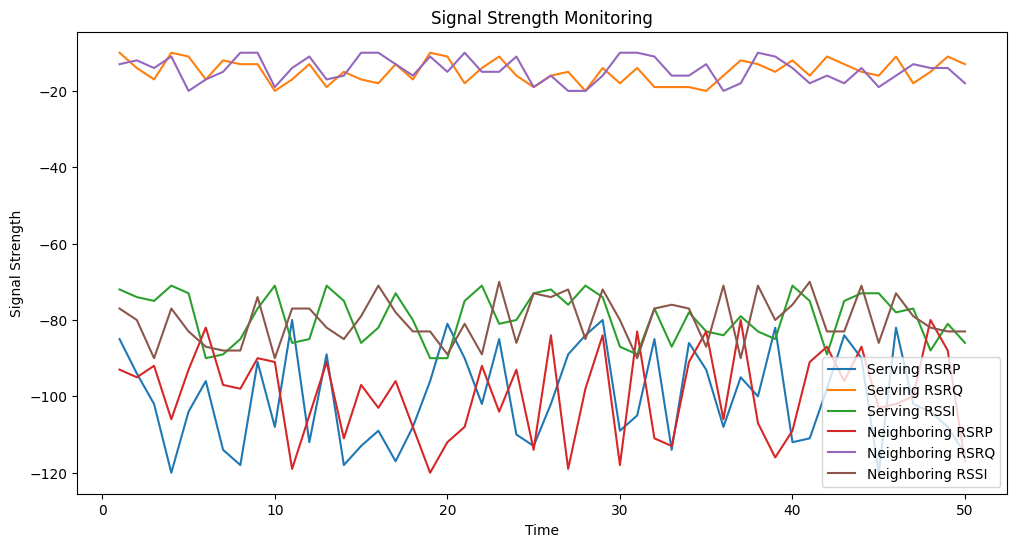

Serving RSRP Mean: -100.26
Serving RSRP Median: -102.0
Serving RSRQ Standard Deviation: 2.9855652731099345


In [ ]:
import random
import time
import csv
import matplotlib.pyplot as plt
import numpy as np
import logging

# Configure logging
logging.basicConfig(filename='signal_strength.log', level=logging.INFO, format='%(asctime)s %(levelname)s: %(message)s')

# Define handover threshold
HANDOVER_THRESHOLD = 70

# Define event threshold
EVENT_THRESHOLD = 90

# Define hysteresis values
HANDOVER_HYSTERESIS = 5
EVENT_HYSTERESIS = 3

# Define signal quality trend thresholds
SIGNAL_QUALITY_TREND_THRESHOLD = 3

# Define LTE parameters
lte_params = {
    'frequency': 1800,  # in MHz
    'bs_tx_power': 46,  # in dBm
    'noise_figure': 9,  # in dB
    'bandwidth': 10e6,  # in Hz
}

# Define function to generate random signal strengths (RSRP, RSRQ, RSSI) for serving and neighboring eNBs based on user location and LTE parameters
def generate_signal_strength(user_location):
    serving_rsrp = calculate_rsrp(user_location, lte_params)
    serving_rsrq = calculate_rsrq(user_location, lte_params)
    serving_rssi = calculate_rssi(user_location, lte_params)
    neighboring_rsrp = calculate_rsrp(user_location, lte_params)
    neighboring_rsrq = calculate_rsrq(user_location, lte_params)
    neighboring_rssi = calculate_rssi(user_location, lte_params)
    return serving_rsrp, serving_rsrq, serving_rssi, neighboring_rsrp, neighboring_rsrq, neighboring_rssi

# Define function to calculate RSRP based on user location and LTE parameters
def calculate_rsrp(user_location, lte_params):
    # Implement the RSRP calculation based on user location and LTE parameters
    # Example calculation using random value for demonstration
    rsrp = random.randint(-120, -80)
    return rsrp

# Define function to calculate RSRQ based on user location and LTE parameters
def calculate_rsrq(user_location, lte_params):
    # Implement the RSRQ calculation based on user location and LTE parameters
    # Example calculation using random value for demonstration
    rsrq = random.randint(-20, -10)
    return rsrq

# Define function to calculate RSSI based on user location and LTE parameters
def calculate_rssi(user_location, lte_params):
    # Implement the RSSI calculation based on user location and LTE parameters
    # Example calculation using random value for demonstration
    rssi = random.randint(-90, -70)
    return rssi

# Define function to check if handover is needed
def is_handover_needed(serving_rsrp, serving_rsrq, serving_rsrp_trend):
    if serving_rsrp < HANDOVER_THRESHOLD - HANDOVER_HYSTERESIS and serving_rsrp_trend < -SIGNAL_QUALITY_TREND_THRESHOLD:
        return True
    return False

# Define function to check if event is triggered
def is_event_triggered(serving_rsrq, neighboring_cell_load, congestion):
    if serving_rsrq > EVENT_THRESHOLD + EVENT_HYSTERESIS and neighboring_cell_load < congestion:
        return True
    return False

# Define function to calculate signal quality trend
def calculate_signal_quality_trend(values):
    if len(values) < 2:
        return 0
    return values[-1] - values[-2]

# Define function to perform handover
def perform_handover():
    print("Handover initiated...")
    logging.info("Handover initiated")

# Define main function
def main():
    try:
        # Generate initial signal strengths (RSRP, RSRQ, RSSI) for serving and neighboring eNBs
        user_location = (0, 0)  # Initial user location in 2D (x, y) coordinates
        serving_rsrp, serving_rsrq, serving_rssi, neighboring_rsrp, neighboring_rsrq, neighboring_rssi = generate_signal_strength(user_location)

        # Define empty lists for data collection
        serving_rsrp_data = []
        serving_rsrq_data = []
        serving_rssi_data = []
        neighboring_rsrp_data = []
        neighboring_rsrq_data = []
        neighboring_rssi_data = []

        # Define empty list for serving RSRP trend
        serving_rsrp_trend_data = []

        # Define loop counter
        iterations = 0

        # Create a CSV file for logging data
        with open('signal_data.csv', mode='w', newline='') as file:
            writer = csv.writer(file)
            writer.writerow(['Iteration', 'Serving RSRP', 'Serving RSRQ', 'Serving RSSI', 'Neighboring RSRP', 'Neighboring RSRQ', 'Neighboring RSSI'])

            # Loop while counter is less than 50
            while iterations < 50:
                # Generate new signal strengths (RSRP, RSRQ, RSSI) for serving and neighboring eNBs based on user location
                new_serving_rsrp, new_serving_rsrq, new_serving_rssi, new_neighboring_rsrp, new_neighboring_rsrq, new_neighboring_rssi = generate_signal_strength(user_location)

                # Calculate the serving RSRP trend
                serving_rsrp_trend = calculate_signal_quality_trend(serving_rsrp_data)

                # Check if handover is needed
                if is_handover_needed(new_serving_rsrp, new_serving_rsrq, serving_rsrp_trend):
                    perform_handover()
                    serving_rsrp, serving_rsrq, serving_rssi = new_serving_rsrp, new_serving_rsrq, new_serving_rssi
                    neighboring_rsrp, neighboring_rsrq, neighboring_rssi = new_neighboring_rsrp, new_neighboring_rsrq, new_neighboring_rssi
                # Check if event is triggered
                elif is_event_triggered(new_serving_rsrq, neighboring_rsrq, serving_rsrq):
                    print("Event triggered!")
                    logging.info("Event triggered")
                    serving_rsrp, serving_rsrq, serving_rssi = new_serving_rsrp, new_serving_rsrq, new_serving_rssi
                    neighboring_rsrp, neighboring_rsrq, neighboring_rssi = new_neighboring_rsrp, new_neighboring_rsrq, new_neighboring_rssi
                else:
                    serving_rsrp, serving_rsrq, serving_rssi = new_serving_rsrp, new_serving_rsrq, new_serving_rssi
                    neighboring_rsrp, neighboring_rsrq, neighboring_rssi = new_neighboring_rsrp, new_neighboring_rsrq, new_neighboring_rssi

                # Append the signal strength values to the data lists
                serving_rsrp_data.append(serving_rsrp)
                serving_rsrq_data.append(serving_rsrq)
                serving_rssi_data.append(serving_rssi)
                neighboring_rsrp_data.append(neighboring_rsrp)
                neighboring_rsrq_data.append(neighboring_rsrq)
                neighboring_rssi_data.append(neighboring_rssi)

                # Append data to the CSV file
                writer.writerow([iterations+1, serving_rsrp, serving_rsrq, serving_rssi, neighboring_rsrp, neighboring_rsrq, neighboring_rssi])

                # Update user location and velocity based on real data or movement simulation
                user_location = update_user_location(user_location)

                # Increment loop counter
                iterations += 1

                # Sleep for 1 second
                time.sleep(1)

        # Plotting the data
        time_steps = range(1, iterations+1)

        plt.figure(figsize=(12, 6))
        plt.plot(time_steps, serving_rsrp_data, label='Serving RSRP')
        plt.plot(time_steps, serving_rsrq_data, label='Serving RSRQ')
        plt.plot(time_steps, serving_rssi_data, label='Serving RSSI')
        plt.plot(time_steps, neighboring_rsrp_data, label='Neighboring RSRP')
        plt.plot(time_steps, neighboring_rsrq_data, label='Neighboring RSRQ')
        plt.plot(time_steps, neighboring_rssi_data, label='Neighboring RSSI')
        plt.xlabel('Time')
        plt.ylabel('Signal Strength')
        plt.title('Signal Strength Monitoring')
        plt.legend()
        plt.show()

        # Statistical analysis
        print("Serving RSRP Mean:", np.mean(serving_rsrp_data))
        print("Serving RSRP Median:", np.median(serving_rsrp_data))
        print("Serving RSRQ Standard Deviation:", np.std(serving_rsrq_data))
        # Perform similar calculations for other signal strength parameters

    except Exception as e:
        print("An error occurred:", str(e))
        logging.error("An error occurred: %s", str(e))

# Function to update user location based on movement simulation or real data
def update_user_location(current_location):
    # Simulating random movement in the x and y coordinates
    x_movement = random.uniform(-1, 1)
    y_movement = random.uniform(-1, 1)
    new_location = (current_location[0] + x_movement, current_location[1] + y_movement)
    return new_location

# Call main function
if __name__ == '__main__':
    main()
